<a href="https://colab.research.google.com/github/francobarrionuevoenv21/PaddyFieldsDetct_ImageSegm/blob/main/UNETs_training_paddyfieldsV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

### About the Project

The project consists of training a Convolutional Neural Network to detect active/in-production paddy fields in a region in northern Santa Fe, Argentina. This area was originally characterized by wetlands, but in recent decades these natural ecosystems have been converted into paddy fields.

The approach will involve training a basic [U-Net neural network](https://www.geeksforgeeks.org/machine-learning/u-net-architecture-explained/) along with two variations. These variations will use different backbones and pretrained weights.

### Notebook Description

In this notebook, three U-Nets variations to detect active/in-production paddy fields in the study area will be trained. For this purpose will be used the L8 data chips and its masks prepared before.

# Code Development

In [ ]:
## INSTALL DEPENDENCIES AND IMPORT LIBRARIES

# Standard and files
import os
import json
import zipfile
from google.colab import files
from datetime import datetime

# Data & Viz
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
import albumentations as A

# Model Tensorflow and Keras
import tensorflow as tf
import keras
from keras import Sequential
from keras.models import load_model, Model
from keras.layers import Conv2D, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score
from keras.metrics import MeanIoU

# Model Segmenetation framework
!pip install segmentation-models -q
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models.losses import bce_jaccard_loss, binary_focal_dice_loss
from segmentation_models.metrics import iou_score
from segmentation_models import get_preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.9 MB/s eta 0:00:00
Segmentation Models: using `tf.keras` framework.


## Data Loading and Augmentation

### Data Loading

In [ ]:
### DATA IMPORTING

In [ ]:
# UNZIP FOLDER WITH CHIPS FOR TRAINING

# Set file path and create output folder
zip_file_path = '...'
destination_folder = '/content'
os.makedirs(destination_folder, exist_ok=True) ## Create the destination folder if it doesn't exist

# Unzip file in the destionatio folder
!unzip -q {zip_file_path} -d {destination_folder}

print('Folder unzipped correctly')

In [ ]:
# GET CHIPS OF IMAGES AND MASKS PATH
images = []
mask = []

image_path = '...'
mask_path = '...'

## Sort directions
image_names = sorted(next(os.walk(image_path))[-1])
mask_names = sorted(next(os.walk(mask_path))[-1])

if image_names == mask_names:
  print('Chips of images and mask correctly located')

Chips of images and mask correctly located


In [ ]:
# CREATE FUNCTION TO LOAD IMAGES AND MASKS
def load_images_and_masks(path_img, image_paths, path_mask, mask_paths, img_size=(128, 128, 5), mask_size=(128, 128, 1)):
    '''
    This functions takes images and masks path to load them as numpy arrays and normalizes its values to 0-1
    '''
    images = [resize(imread(path_img+path), img_size, preserve_range=True) for path in image_paths]
    masks = [resize(imread(path_mask+path), mask_size, preserve_range=True) for path in mask_paths]

    images = np.array(images, dtype=np.float32)
    masks = np.array(masks, dtype=np.float32)

    ## Values normalization 0-1
    images /= 255.0
    masks /= 255.0

    return images, masks

In [ ]:
# LOAD IMAGES AND MASKS FOR TRAINING

## Set images and masks dimensiones
img_size = (128, 128, 5)
mask_size = (128, 128, 1)

## LOAD IMAGES AND MASKS WITH FUNCTION
images, masks = load_images_and_masks(image_path, image_names, mask_path, mask_names, img_size, mask_size)

In [ ]:
# DEFINE FUNCTION TO VISUALIZE CHIPS AND MASKS
def show_image(image, cmap=None, title=None):
  '''
  The function takes an image in numpy array format and displays it.
  '''
  plt.imshow(image, cmap=cmap)
  if title is not None: plt.title(title, fontsize=10)
  plt.axis('off')

In [ ]:
# DISPLAY RANDOM CHIPS AND ITS MASKS

plt.figure(figsize=(9,9))
for i in range(1, 9):
  plt.subplot(5,4,i)

  if i%2!=0:
    id = np.random.randint(len(images))
    show_image(images[id][:,:,:3], title="Orginal Image")
  elif i%2==0:
    show_image(masks[id].reshape(128,128), title="Mask Image", cmap='gray')

plt.tight_layout()
plt.show()

### Data augmentation and splitting

In [ ]:
# DATA SPLITING

## Exchange data variables
X, y = images, masks

## Set data splitting ratios
train_ratio = 0.7
validation_ratio = 0.2
test_ratio = 0.1

## Split train-eval (70%-30%)
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=(1-train_ratio), random_state=42)

## Split test-val
X_val, X_test, y_val, y_test = train_test_split(X_eval, y_eval, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

In [ ]:
# TRAIN DATA AUGMENTATION WITH ALBUMENTATIONS

## Define images and masks transformations: flipping, rotations, brighting, noissing and blurring
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.05,
        scale_limit=0.1,
        rotate_limit=10,
        border_mode=0,     # pad with zeros
        p=0.5
    ),

    A.RandomBrightnessContrast(
        brightness_limit=0.1,
        contrast_limit=0.1,
        p=0.3
    ),
    A.GaussNoise(
        var_limit=(5.0, 30.0),
        p=0.2
    ),
    A.Blur(blur_limit=3, p=0.1),
])

# Define a function to apply transformations
def augment(image, mask):
    '''
    The functions takes as input the images and masks as numpy arrays and returns
    the augmented images and masks
    '''
    augmented = transform(image=image, mask=mask)
    image_aug = augmented["image"]
    mask_aug = augmented["mask"]
    return image_aug, mask_aug

## Apply data augmentation to test data
aug_images = []
aug_masks = []

for img, msk in zip(X_train, y_train):
    img_aug, msk_aug = augment(img, msk)
    aug_images.append(img_aug)
    aug_masks.append(msk_aug)

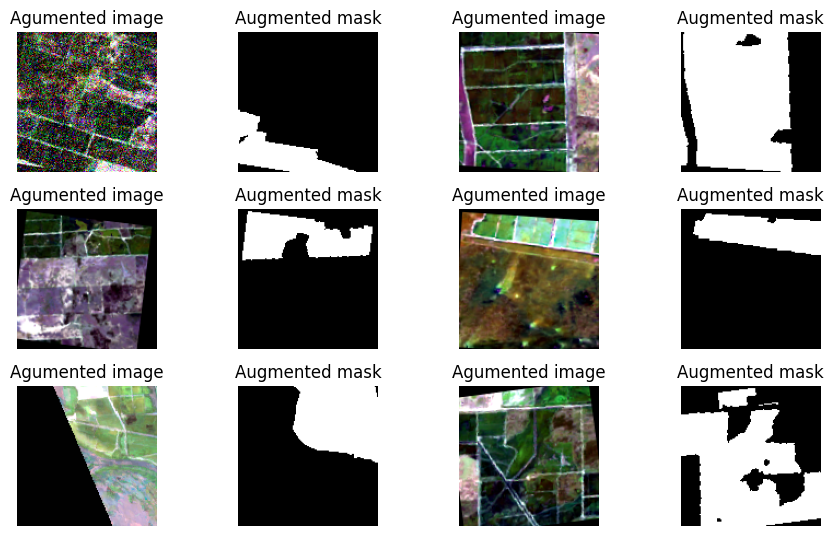

In [ ]:
# DISPLAY RANDOM CHIPS AND ITS MASKS (AUGMENTED)

plt.figure(figsize=(9,9))
for i in range(1,13):
  plt.subplot(5,4,i)

  if i%2!=0:
    id = np.random.randint(len(aug_images))
    show_image(aug_images[id][:,:,:3], title="Agumented image")
  elif i%2==0:
    show_image(aug_masks[id].reshape(128,128), title="Augmented mask", cmap='gray')

plt.tight_layout()
plt.show()

In [ ]:
X_train_aug = np.concatenate([X_train, aug_images], axis=0)
y_train_aug  = np.concatenate([y_train, aug_masks], axis=0)

print('Shape original training data', X_train.shape, y_train.shape)
print('Shape augmented training data', X_train_aug.shape, y_train_aug.shape)

Shape original training data (2207, 128, 128, 5) (2207, 128, 128, 1)
Shape augmented training data (4414, 128, 128, 5) (4414, 128, 128, 1)


## Models training

For the segmentation and identification of the paddy fields in the study area, three U-Nets variations will be trained according to [Wang et al. (2022)](https://doi.org/10.3390/agronomy12102342): simple U-net, ResNet34-based U-net, and SeresNet34-based U-net. Pre-trained weights on the ImageNet dataset will be adopted for the backbone networks due the small training resources. The U-Net based models will be implemented using the [Segmentation Models framework](https://github.com/qubvel/segmentation_models). The training parameters defined are:

*Optimizer*: Adam\
*Epochs*: 150\
*Batch Size*: 16\
*Loss Function*: Focal + Dice loss \
*Metrics*: IOU

### Callbacks Settings

In [ ]:
# Define a Callback to show training process
class ShowProgress(keras.callbacks.Callback):
  def __init__(self, save=False):
    self.save = save
  def on_epoch_end(self, epoch, logs=None):
    id = np.random.randint(len(images))
    real_img = images[id][np.newaxis,...]
    pred_mask = self.model.predict(real_img).reshape(128,128)
    proc_mask1 = post_process(pred_mask)
    proc_mask2 = post_process(pred_mask, threshold=0.5)
    proc_mask3 = post_process(pred_mask, threshold=0.9)
    mask = masks[id].reshape(128,128)

    plt.figure(figsize=(7,4))

    plt.subplot(1,6,1)
    show_image(real_img[0][:,:,:3], title="Orginal Image")

    plt.subplot(1,6,2)
    show_image(pred_mask, title="Predicted Mask", cmap='gray')

    plt.subplot(1,6,3)
    show_image(mask, title="Orginal Mask", cmap='gray')

    plt.subplot(1,6,4)
    show_image(proc_mask1, title="Processed@0.4", cmap='gray')

    plt.subplot(1,6,5)
    show_image(proc_mask2, title="Processed@0.5", cmap='gray')

    plt.subplot(1,6,6)
    show_image(proc_mask3, title="Processed@0.9", cmap='gray')

    plt.tight_layout()
    if self.save: plt.savefig("Progress-{}.png".format(epoch+1))
    plt.show()

# Post Process
def post_process(image,threshold=0.4):
  return image>threshold

In [ ]:
# DEFINE CALLBACKS FOR EACH TRAINING ALTERNATIVE

# NOTE: For make the model lighter, and then easier to load when using for predicting,
# only weights will be saved

# Define filenames for each model alternative

filename_alt1 = 'UNet-01.weights.h5'
filename_alt2 = 'UNet-02.weights.h5'
filename_alt3 = 'UNet-03.weights.h5'

# Callback settings for alternative 1
callbacks_01 = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(filename_alt1, save_best_only=True, save_weights_only=True),
    ShowProgress(save=True)
]

# Callback settings for alternative 2
callbacks_02 = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint(filename_alt2, save_best_only=True, save_weights_only=True),
    ShowProgress(save=True)
]

# Callback settings for alternative 3
callbacks_03 = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint(filename_alt3,save_best_only=True),
    ShowProgress(save=True)
]

### Models evaluation and exporting

In [ ]:
# CREATE FUNCTIONS TO ASSES TRAINED MODELS

# Creates a function to plot training parameters progression
def plot_params_train(model_ev, AX_idx, model_name):
  '''
  This functions takes as input the model to evaluate and plots its training
  parameters progression
  '''
  list_param = list(model_ev.history.history.keys())
  for p in range(len(list_param)):
    AX_idx.plot(range(len(model_ev.history.history[list_param[p]])), model_ev.history.history[list_param[p]], label=list_param[p])

  AX_idx.legend()
  AX_idx.set_title(f"Training parameters evaluation-{model_name}", fontsize = 14)
  AX_idx.set_xlabel("Epoch", fontsize= 14)
  AX_idx.set_ylabel("Parameter value by epoch", fontsize= 14)

# Creates a function to predict test data with the trained model
def model_test_output(model_ev, X_test):
  '''
  This functions takes as input the model to evaluate and the test data, and
  returns the model predictions
  '''
  return model_ev.predict(X_test)

# Creates a function to get IOU results for different thresholds
def get_iou(y_predict, y_test):
  '''
  This function takes the predictions of the evaluated model and the y test data,
  and returns the IOU results for different thresholds as a list, the best IOU
  and its threshold
  '''
  # Initalization
  array_thrs = np.arange(0.05, 1, 0.05)
  list_iou_res = []

  n_classes = 2 # 1 o 0

  # Evaluate every threshold
  for t in array_thrs:
    unet_pred_thrs = y_predict.copy()
    unet_pred_thrs[unet_pred_thrs>=t] = 1
    unet_pred_thrs[unet_pred_thrs<t] = 0

    mean_iou_metric = MeanIoU(num_classes=n_classes)
    mean_iou_metric.update_state(y_test, unet_pred_thrs)

    list_iou_res.append(mean_iou_metric.result().numpy())

  max_iou = list_iou_res[np.argmax(np.array(list_iou_res))]
  max_thrs = array_thrs[np.argmax(np.array(list_iou_res))]

  return list_iou_res, max_iou, max_thrs

# Creates a function that plts IOU vs threshold
def plot_iou(iou_list, max_iou, max_thrs, AX_idx, model_name):
  '''
  This function takes as input the IOU results by thresholds and best results,
  to display them togheter
  '''
  AX_idx.plot(np.arange(0.05, 1, 0.05), iou_list, label="IOU by Thrsh.")
  AX_idx.plot(max_thrs, max_iou, marker = "o", color="red", label = f"Max IOU: {max_iou:.3f}-Thrsh: {max_thrs:.3f}")

  AX_idx.legend()
  AX_idx.set_title(f"IOU by threshold (Test data)-{model_name}", fontsize = 14)
  AX_idx.set_xlabel("IOU", fontsize= 14)
  AX_idx.set_ylabel("Threshold", fontsize= 14)

# Creates a function to get precission and recall for the best threshold
def get_PRmetrics(y_predict, y_test, max_thrs):
  '''
  This functions takes as input the model predictions, y test data, and best
  threshold to get the precission and recall metrics
  '''
  y_predict_thrs = y_predict.copy()
  y_predict_thrs[y_predict_thrs>=max_thrs] = 1
  y_predict_thrs[y_predict_thrs<max_thrs] = 0

  precision = precision_score(y_test.flatten(), y_predict_thrs.flatten())
  recall = recall_score(y_test.flatten(), y_predict_thrs.flatten())

  return precision, recall

# Creates a function that plots random predictions for best model
def plot_test_random(X_test, y_test, y_predict, max_thrs):
  '''
  This functions takes test data and predictions to plot random predictions
  '''
  fig, axes = plt.subplots(3, 3, figsize=(6, 6))

  for i in range(3):

    id = np.random.randint(len(X_test))
    axes[i, 0].imshow(X_test[id][:,:,:3])
    axes[i, 0].set_title("Original RGB image")
    axes[i, 1].imshow(y_test[id], cmap='Grays_r')
    axes[i, 1].set_title("Mask")
    img_pred = y_predict[id].reshape(128,128)
    axes[i, 2].imshow(img_pred>max_thrs, cmap='Grays_r')
    axes[i, 2].set_title(f"Prediction Threshold: {max_thrs:.3f}")

  plt.tight_layout()
  plt.show()

In [ ]:
# CREATES FUNCTIONS THAT SUMMARY MODEL PARAMETERS AND COMPRESS IT WITH MODEL
# WEIGHTS TO EXPORT THEM

# Creates a function that gather model parameters and export them as json file
def create_model_info(model_name, model_ev, best_iou, best_thrs, best_precs, best_recall):
  '''
  This function takes as input the model metrics for the best case (best IOU)
  and returns a json file with the model info
  '''
  # Build the text content using an dictionary
  info = {
      "model_name": model_name,
      "training_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
      "epochs": len(model_ev.history.history['val_iou_score']),
      "best_iou": float(best_iou),
      "best_threshold": float(best_thrs),
      "precision": float(best_precs),
      "recall": float(best_recall)
  }

  # Save to a .txt file
  filename = f"{model_name}_info.json"
  with open(filename, "w") as f:
      json.dump(info, f, indent=4)

  return filename

# Creates a function to compress model weights and info
def down_zip(model_name_str, model_w, model_i):
  '''
  This function takes as input the model weights file and info file, and
  returns a zip file with both files
  '''
  zip_path = f"/content/{model_name_str}.zip"

  # Compress files
  with zipfile.ZipFile(zip_path, 'w') as zipf:
      zipf.write(model_w, arcname=model_w.split('/')[-1])
      zipf.write(model_i, arcname=model_i.split('/')[-1])

  # Download zip file
  files.download(zip_path)

### **Alternative 1**:  Simple U-Net

#### Model implementation

**NOTE**: U-Net architecture implementation is based in the TensorFlow library [(Source)](https://www.geeksforgeeks.org/machine-learning/u-net-architecture-explained/)

In [ ]:
# DEFINE BASIC UNET COMPONENTS

## Encoder
def encoder_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(inputs)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(x)

    return x

## Decoder
def decoder_block(inputs, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    skip_features = tf.keras.layers.Resizing(x.shape[1], x.shape[2])(skip_features)
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x

# Combine and define the model
def unet_model(input_shape, num_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Contracting Path (Encoder)
    s1 = encoder_block(inputs, 64)
    s2 = encoder_block(s1, 128)
    s3 = encoder_block(s2, 256)
    s4 = encoder_block(s3, 512)

    # Bottleneck
    b1 = tf.keras.layers.Conv2D(1024, 3, padding='same')(s4)
    b1 = tf.keras.layers.Activation('relu')(b1)
    b1 = tf.keras.layers.Conv2D(1024, 3, padding='same')(b1)
    b1 = tf.keras.layers.Activation('relu')(b1)

    # Expansive Path (Decoder)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = tf.keras.layers.Conv2D(num_classes, 1, padding='same', activation='sigmoid')(d4)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='U-Net')

    return model

In [ ]:
# DEFINE THE UNET MODEL AND COMPILE

# Define model name
model_name_str01 = "Simple U-Net"

# Define the model
unet = unet_model(X_train_aug[0].shape, 1)

# Define
unet.compile(
    optimizer=Adam(learning_rate=0.001),
    loss= binary_focal_dice_loss,
    metrics=[iou_score]
)

In [ ]:
# DISPLAY SUMMARY (OPTIONAL)
#unet.summary()

#### Model training

Epoch 1/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


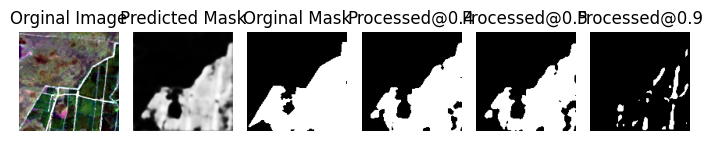

276/276 ━━━━━━━━━━━━━━━━━━━━ 161s 441ms/step - iou_score: 0.2470 - loss: 0.6985 - val_iou_score: 0.3441 - val_loss: 0.6082
Epoch 2/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


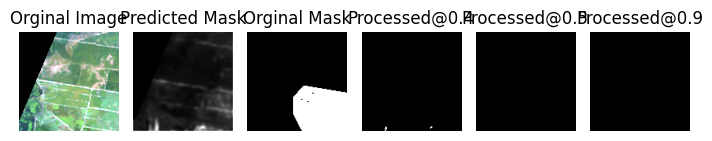

276/276 ━━━━━━━━━━━━━━━━━━━━ 115s 245ms/step - iou_score: 0.3564 - loss: 0.5823 - val_iou_score: 0.4512 - val_loss: 0.4923
Epoch 3/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


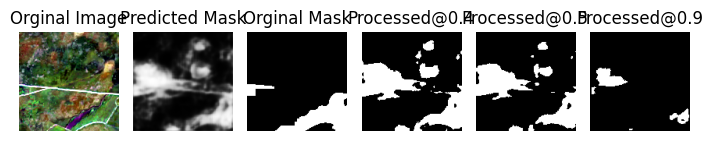

276/276 ━━━━━━━━━━━━━━━━━━━━ 67s 243ms/step - iou_score: 0.4091 - loss: 0.5228 - val_iou_score: 0.4675 - val_loss: 0.4624
Epoch 4/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


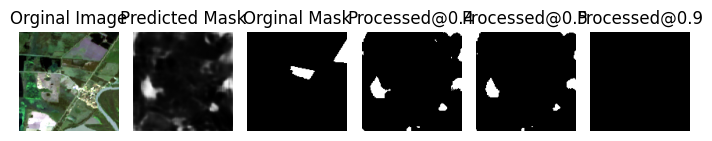

276/276 ━━━━━━━━━━━━━━━━━━━━ 66s 237ms/step - iou_score: 0.4237 - loss: 0.5027 - val_iou_score: 0.4928 - val_loss: 0.4654
Epoch 5/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


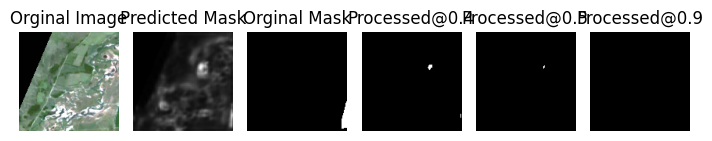

276/276 ━━━━━━━━━━━━━━━━━━━━ 71s 256ms/step - iou_score: 0.4538 - loss: 0.4748 - val_iou_score: 0.4983 - val_loss: 0.4149
Epoch 6/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


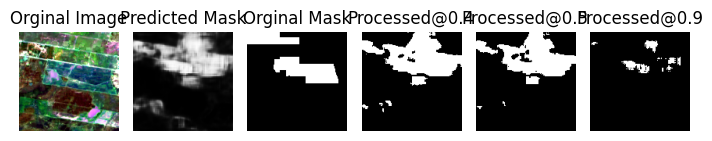

276/276 ━━━━━━━━━━━━━━━━━━━━ 74s 267ms/step - iou_score: 0.4730 - loss: 0.4518 - val_iou_score: 0.5317 - val_loss: 0.3994
Epoch 7/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


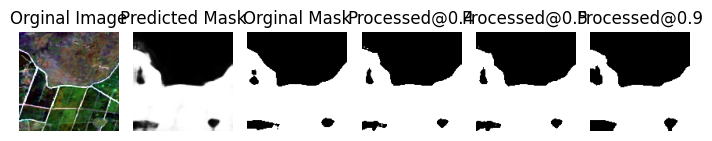

276/276 ━━━━━━━━━━━━━━━━━━━━ 78s 282ms/step - iou_score: 0.4894 - loss: 0.4362 - val_iou_score: 0.5482 - val_loss: 0.3976
Epoch 8/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


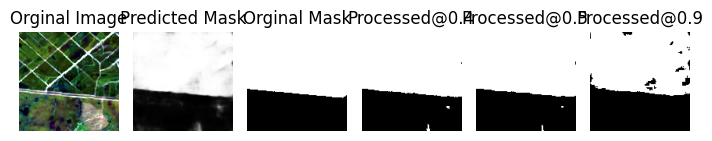

276/276 ━━━━━━━━━━━━━━━━━━━━ 88s 318ms/step - iou_score: 0.5038 - loss: 0.4223 - val_iou_score: 0.5145 - val_loss: 0.3917
Epoch 9/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


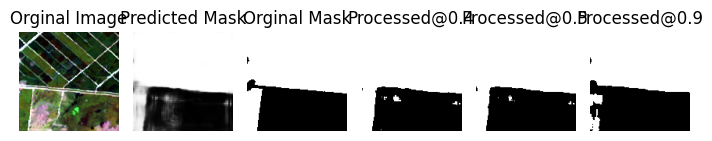

276/276 ━━━━━━━━━━━━━━━━━━━━ 98s 356ms/step - iou_score: 0.5236 - loss: 0.4007 - val_iou_score: 0.5481 - val_loss: 0.3690
Epoch 10/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


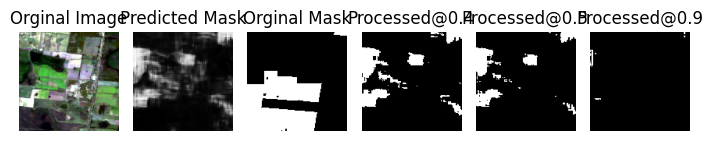

276/276 ━━━━━━━━━━━━━━━━━━━━ 66s 240ms/step - iou_score: 0.5359 - loss: 0.3890 - val_iou_score: 0.5396 - val_loss: 0.3970
Epoch 11/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


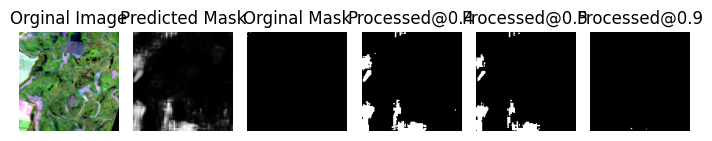

276/276 ━━━━━━━━━━━━━━━━━━━━ 97s 353ms/step - iou_score: 0.5447 - loss: 0.3793 - val_iou_score: 0.5398 - val_loss: 0.3664
Epoch 12/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


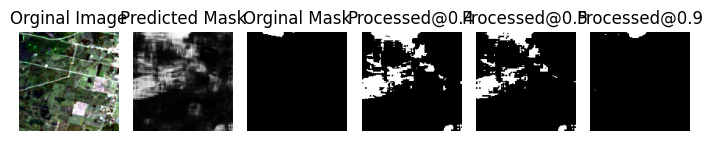

276/276 ━━━━━━━━━━━━━━━━━━━━ 99s 357ms/step - iou_score: 0.5446 - loss: 0.3802 - val_iou_score: 0.5548 - val_loss: 0.3618
Epoch 13/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


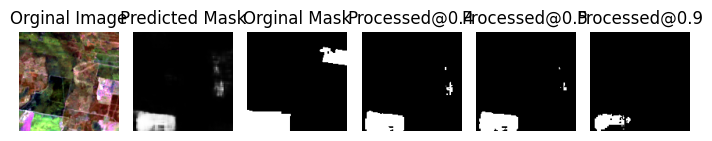

276/276 ━━━━━━━━━━━━━━━━━━━━ 95s 345ms/step - iou_score: 0.5599 - loss: 0.3661 - val_iou_score: 0.5783 - val_loss: 0.3462
Epoch 14/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


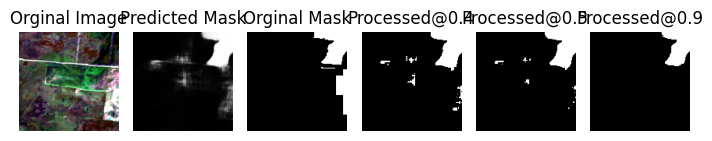

276/276 ━━━━━━━━━━━━━━━━━━━━ 93s 339ms/step - iou_score: 0.5686 - loss: 0.3567 - val_iou_score: 0.5860 - val_loss: 0.3327
Epoch 15/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


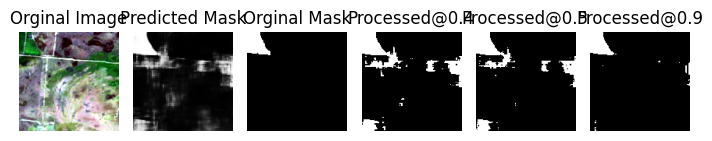

276/276 ━━━━━━━━━━━━━━━━━━━━ 98s 354ms/step - iou_score: 0.5816 - loss: 0.3440 - val_iou_score: 0.5942 - val_loss: 0.3324
Epoch 16/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


276/276 ━━━━━━━━━━━━━━━━━━━━ 66s 239ms/step - iou_score: 0.5836 - loss: 0.3427 - val_iou_score: 0.6021 - val_loss: 0.3483
Epoch 17/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


276/276 ━━━━━━━━━━━━━━━━━━━━ 86s 313ms/step - iou_score: 0.5885 - loss: 0.3384 - val_iou_score: 0.6136 - val_loss: 0.3160
Epoch 18/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


276/276 ━━━━━━━━━━━━━━━━━━━━ 94s 342ms/step - iou_score: 0.6124 - loss: 0.3165 - val_iou_score: 0.6158 - val_loss: 0.3152
Epoch 19/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


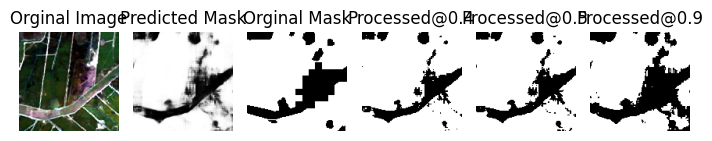

276/276 ━━━━━━━━━━━━━━━━━━━━ 98s 355ms/step - iou_score: 0.6262 - loss: 0.3040 - val_iou_score: 0.6068 - val_loss: 0.3133
Epoch 20/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


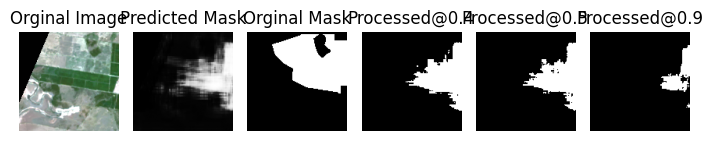

276/276 ━━━━━━━━━━━━━━━━━━━━ 97s 353ms/step - iou_score: 0.6285 - loss: 0.3000 - val_iou_score: 0.6200 - val_loss: 0.3114
Epoch 21/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


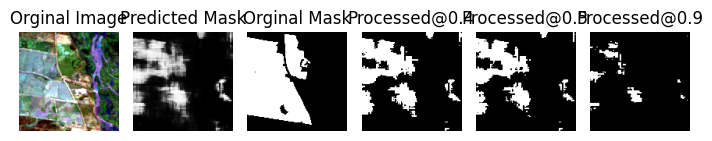

276/276 ━━━━━━━━━━━━━━━━━━━━ 96s 349ms/step - iou_score: 0.6435 - loss: 0.2879 - val_iou_score: 0.6401 - val_loss: 0.2958
Epoch 22/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


276/276 ━━━━━━━━━━━━━━━━━━━━ 93s 338ms/step - iou_score: 0.6548 - loss: 0.2773 - val_iou_score: 0.6522 - val_loss: 0.2825
Epoch 23/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


276/276 ━━━━━━━━━━━━━━━━━━━━ 66s 239ms/step - iou_score: 0.6704 - loss: 0.2640 - val_iou_score: 0.6478 - val_loss: 0.2897
Epoch 24/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


276/276 ━━━━━━━━━━━━━━━━━━━━ 68s 247ms/step - iou_score: 0.6752 - loss: 0.2601 - val_iou_score: 0.6384 - val_loss: 0.2978
Epoch 25/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


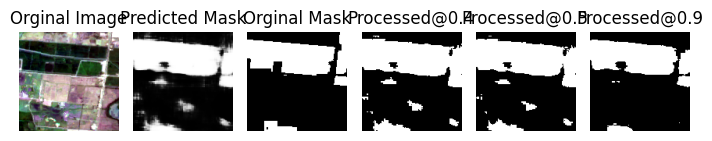

276/276 ━━━━━━━━━━━━━━━━━━━━ 66s 238ms/step - iou_score: 0.6815 - loss: 0.2545 - val_iou_score: 0.6650 - val_loss: 0.3047
Epoch 26/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


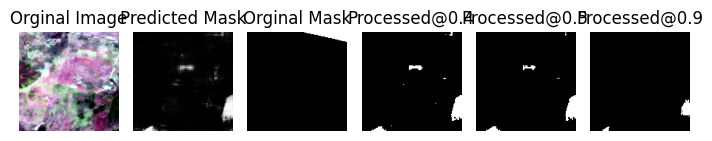

276/276 ━━━━━━━━━━━━━━━━━━━━ 66s 238ms/step - iou_score: 0.7059 - loss: 0.2348 - val_iou_score: 0.6739 - val_loss: 0.2838
Epoch 27/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


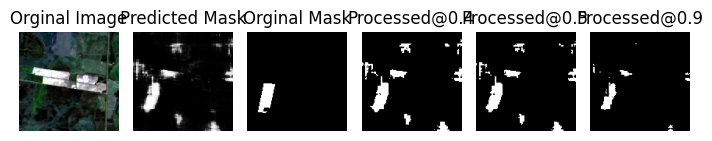

276/276 ━━━━━━━━━━━━━━━━━━━━ 101s 367ms/step - iou_score: 0.7063 - loss: 0.2312 - val_iou_score: 0.6796 - val_loss: 0.2716
Epoch 28/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


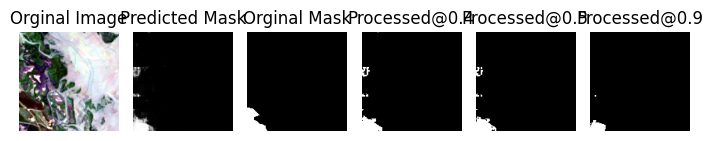

276/276 ━━━━━━━━━━━━━━━━━━━━ 98s 355ms/step - iou_score: 0.7242 - loss: 0.2161 - val_iou_score: 0.6893 - val_loss: 0.2695
Epoch 29/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


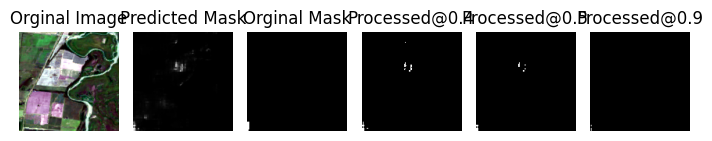

276/276 ━━━━━━━━━━━━━━━━━━━━ 100s 364ms/step - iou_score: 0.7390 - loss: 0.2043 - val_iou_score: 0.6884 - val_loss: 0.2639
Epoch 30/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


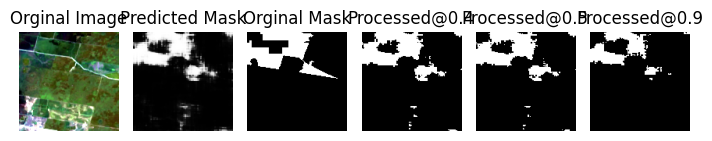

276/276 ━━━━━━━━━━━━━━━━━━━━ 98s 356ms/step - iou_score: 0.7503 - loss: 0.1944 - val_iou_score: 0.6999 - val_loss: 0.2581
Epoch 31/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


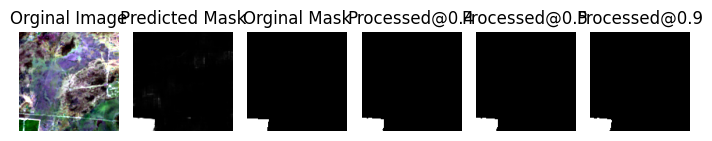

276/276 ━━━━━━━━━━━━━━━━━━━━ 140s 351ms/step - iou_score: 0.7549 - loss: 0.1901 - val_iou_score: 0.6939 - val_loss: 0.2546
Epoch 32/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


276/276 ━━━━━━━━━━━━━━━━━━━━ 66s 239ms/step - iou_score: 0.7559 - loss: 0.1898 - val_iou_score: 0.6897 - val_loss: 0.2573
Epoch 33/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


276/276 ━━━━━━━━━━━━━━━━━━━━ 65s 237ms/step - iou_score: 0.7768 - loss: 0.1725 - val_iou_score: 0.7046 - val_loss: 0.2553
Epoch 34/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


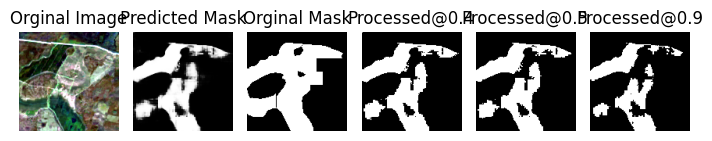

276/276 ━━━━━━━━━━━━━━━━━━━━ 101s 368ms/step - iou_score: 0.7669 - loss: 0.1800 - val_iou_score: 0.7151 - val_loss: 0.2465
Epoch 35/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


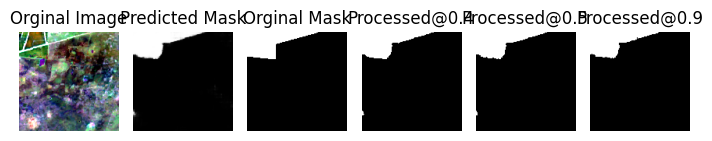

276/276 ━━━━━━━━━━━━━━━━━━━━ 66s 239ms/step - iou_score: 0.7994 - loss: 0.1542 - val_iou_score: 0.7125 - val_loss: 0.2504
Epoch 36/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


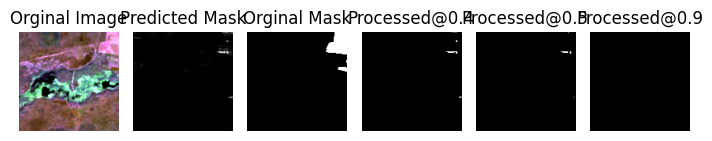

276/276 ━━━━━━━━━━━━━━━━━━━━ 65s 237ms/step - iou_score: 0.7993 - loss: 0.1542 - val_iou_score: 0.6880 - val_loss: 0.2658
Epoch 37/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


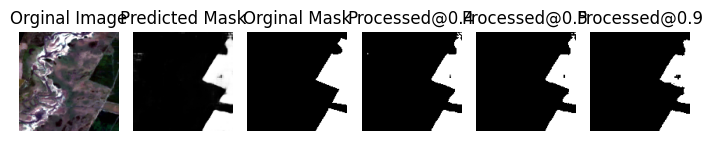

276/276 ━━━━━━━━━━━━━━━━━━━━ 66s 237ms/step - iou_score: 0.7931 - loss: 0.1584 - val_iou_score: 0.7082 - val_loss: 0.2608
Epoch 38/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


276/276 ━━━━━━━━━━━━━━━━━━━━ 66s 238ms/step - iou_score: 0.7991 - loss: 0.1534 - val_iou_score: 0.7164 - val_loss: 0.2488
Epoch 39/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


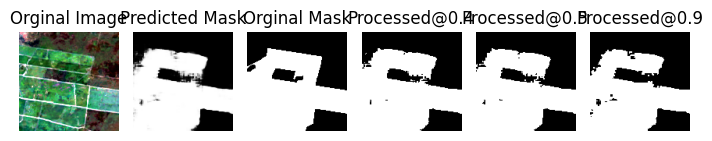

276/276 ━━━━━━━━━━━━━━━━━━━━ 65s 237ms/step - iou_score: 0.8207 - loss: 0.1366 - val_iou_score: 0.7246 - val_loss: 0.2486


In [ ]:
# TRAIN THE MODEL
unet_result = unet.fit(
    X_train_aug, y_train_aug,
    validation_data = (X_val, y_val), batch_size = 16, epochs = 150,
    callbacks = callbacks_01)

#### Trained model metrics evaluation

In [ ]:
# EVALUATE IOU METRIC OF THE TRAINED MODEL

# Define model to evalue
model_ev01 = unet

# Predict with test data
model_ev01_pred = model_test_output(model_ev01, X_test)

# Evaluate trained model and get the best IOU and its threshold
list_iou_resev01, max_iouev01, max_thrsev01 = get_iou(model_ev01_pred, y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step


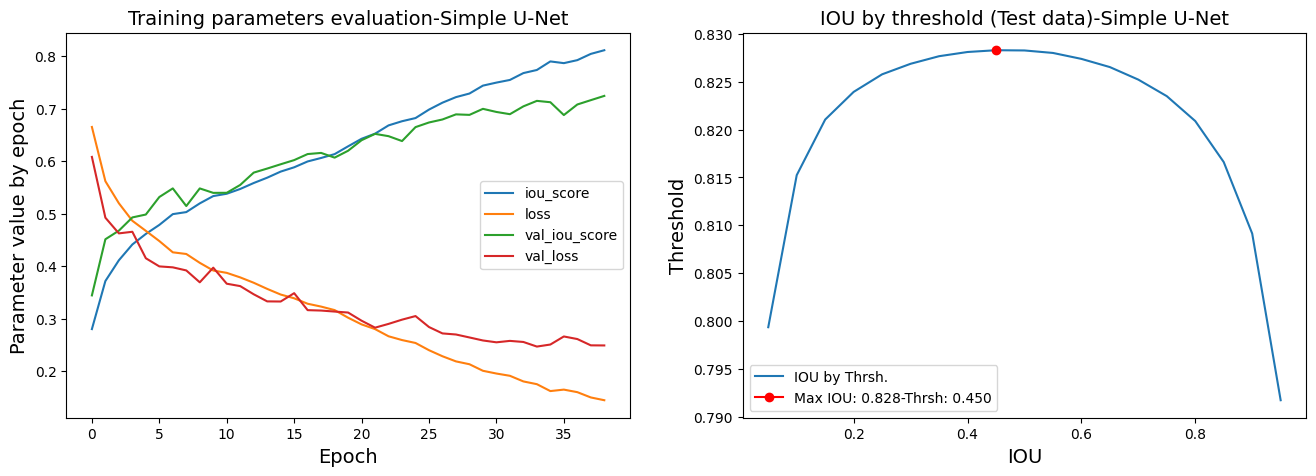

In [ ]:
# PLOT MODEL METRICS

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot training parameters
plot_params_train(model_ev01, axes[0], model_name_str01)

# Plot IOU by threshold and the best case
plot_iou(list_iou_resev01, max_iouev01, max_thrsev01, axes[1], model_name_str01)

plt.show()

In [ ]:
# GET METRICS FOR BEST CASE AND SUMMARY THEM

# Get precission and recall for the beset case
precsev01, recallev01 = get_PRmetrics(model_ev01_pred, y_test, max_thrsev01)

# Summary model metrics
print("FINAL METRICS RESULTS: ", model_name_str01)
print(f"IOU with threshold {max_thrsev01:.3f}: {max_iouev01:.3f}")
print(f"Precision with threshold {max_thrsev01:.3f}: {precsev01:.3f}")
print(f"Recall with threshold {max_thrsev01:.3f}: {recallev01:.3f}")

FINAL METRICS RESULTS:  Simple U-Net
IOU with threshold 0.450: 0.828
Precision with threshold 0.450: 0.886
Recall with threshold 0.450: 0.824


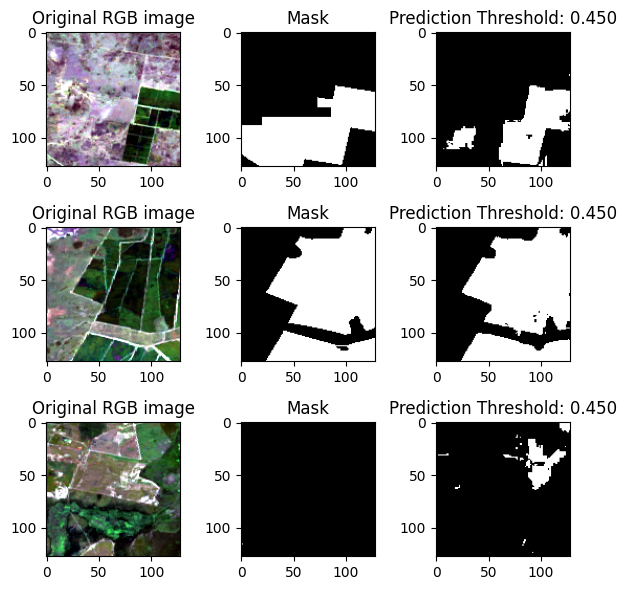

In [ ]:
# PLOT RANDOM PREDICTIONS BASED ON TEST DATA

plot_test_random(X_test, y_test, model_ev01_pred, max_thrsev01)

#### Save and download trained model weights and info

In [ ]:
# GET TRAINED MODEL INFO AND SAVE IT WITH WEIGHTS AS A ZIP FILE

# Get trained model info
path_info_ev01 = create_model_info(model_name_str01, model_ev01, max_iouev01, max_thrsev01, precsev01, recallev01)

# Compress and download model weights and info as a zip file
down_zip(model_name_str01, filename_alt1, path_info_ev01)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Alternative 2**:  U-Net + Backbone: ResNet 34

#### Model implementation

**NOTE**: U-Nen + ResNet architecture implementation is based in the [Segmentation Models framework](https://github.com/qubvel/segmentation_models/tree/master)

In [ ]:
# DEFINE UNET ALTERNATIVE COMPONENTS

# Define the model name
model_name_str02 = "U-Net + Backbone: ResNet 34"

# Define backbone
BACKBONE_01 = 'resnet34'

# Define base model
## The model is initialized using imagenet pretrained weights
base_model_r34 = Unet(backbone_name=BACKBONE_01, encoder_weights='imagenet')

# Get number of channels
N = X_train.shape[-1] # N = 5. Bands:RGB, NIR & NDVI

# Add extra convolutional layer to map N channels to 3
inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model_r34(l1)

# Define model
unet_r34 = Model(inp, out, name=base_model_r34.name)

# Compile the model
unet_r34.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=binary_focal_dice_loss,
                  metrics=[iou_score])

# Preprocess training data
preprocess_input = get_preprocessing(BACKBONE_01)
X_train_A2 = preprocess_input(X_train_aug)
X_val_A2 = preprocess_input(X_val)

85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# DISPLAY SUMMARY (OPTIONAL)
#unet_r34.summary()

#### Model training

Epoch 1/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


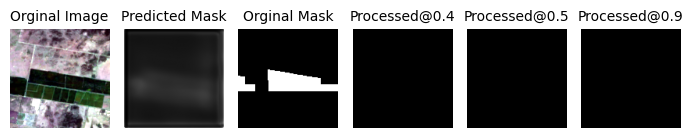

276/276 ━━━━━━━━━━━━━━━━━━━━ 143s 340ms/step - iou_score: 0.3520 - loss: 0.5859 - val_iou_score: 0.0323 - val_loss: 1.1460
Epoch 2/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


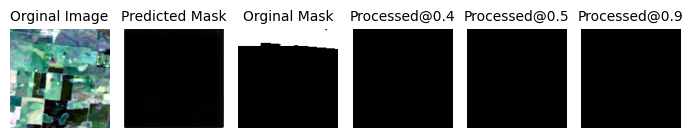

276/276 ━━━━━━━━━━━━━━━━━━━━ 33s 119ms/step - iou_score: 0.4660 - loss: 0.4626 - val_iou_score: 0.0029 - val_loss: 1.4116
Epoch 3/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


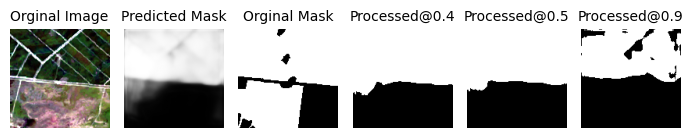

276/276 ━━━━━━━━━━━━━━━━━━━━ 65s 235ms/step - iou_score: 0.5506 - loss: 0.3765 - val_iou_score: 0.4561 - val_loss: 0.4769
Epoch 4/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


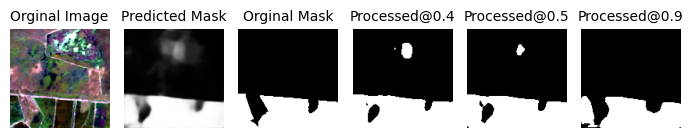

276/276 ━━━━━━━━━━━━━━━━━━━━ 61s 222ms/step - iou_score: 0.5656 - loss: 0.3654 - val_iou_score: 0.5487 - val_loss: 0.4251
Epoch 5/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


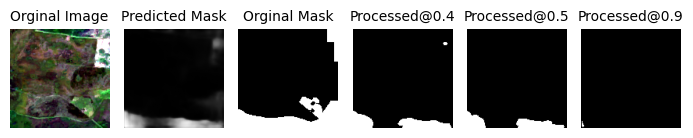

276/276 ━━━━━━━━━━━━━━━━━━━━ 70s 252ms/step - iou_score: 0.6030 - loss: 0.3239 - val_iou_score: 0.6482 - val_loss: 0.2851
Epoch 6/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


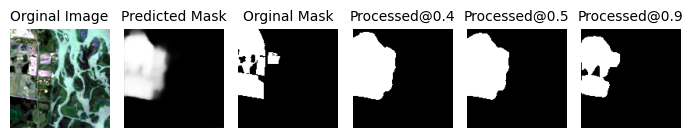

276/276 ━━━━━━━━━━━━━━━━━━━━ 58s 210ms/step - iou_score: 0.6611 - loss: 0.2734 - val_iou_score: 0.7268 - val_loss: 0.2351
Epoch 7/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


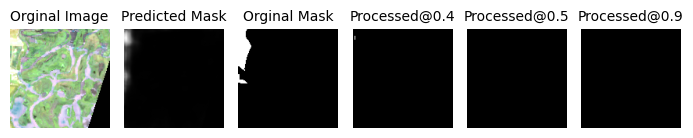

276/276 ━━━━━━━━━━━━━━━━━━━━ 33s 120ms/step - iou_score: 0.6918 - loss: 0.2467 - val_iou_score: 0.6813 - val_loss: 0.2508
Epoch 8/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


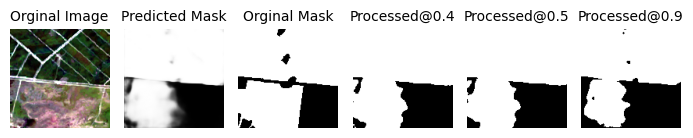

276/276 ━━━━━━━━━━━━━━━━━━━━ 33s 120ms/step - iou_score: 0.7253 - loss: 0.2166 - val_iou_score: 0.6908 - val_loss: 0.2608
Epoch 9/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


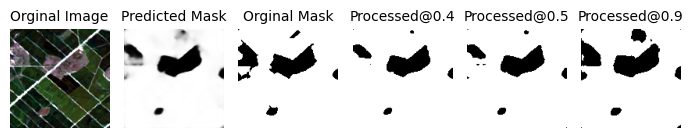

276/276 ━━━━━━━━━━━━━━━━━━━━ 64s 234ms/step - iou_score: 0.7349 - loss: 0.2081 - val_iou_score: 0.7431 - val_loss: 0.2092
Epoch 10/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


276/276 ━━━━━━━━━━━━━━━━━━━━ 65s 237ms/step - iou_score: 0.7611 - loss: 0.1858 - val_iou_score: 0.7694 - val_loss: 0.1916
Epoch 11/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


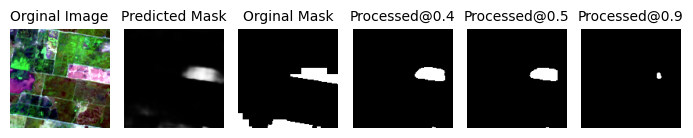

276/276 ━━━━━━━━━━━━━━━━━━━━ 76s 275ms/step - iou_score: 0.7979 - loss: 0.1547 - val_iou_score: 0.8027 - val_loss: 0.1547
Epoch 12/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


276/276 ━━━━━━━━━━━━━━━━━━━━ 74s 268ms/step - iou_score: 0.8118 - loss: 0.1446 - val_iou_score: 0.8255 - val_loss: 0.1290
Epoch 13/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


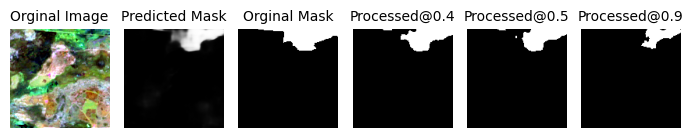

276/276 ━━━━━━━━━━━━━━━━━━━━ 33s 121ms/step - iou_score: 0.8269 - loss: 0.1317 - val_iou_score: 0.8105 - val_loss: 0.1444
Epoch 14/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


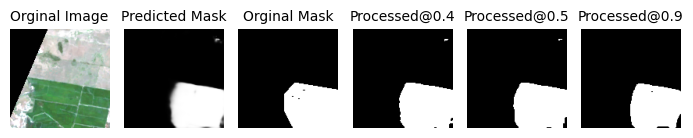

276/276 ━━━━━━━━━━━━━━━━━━━━ 71s 257ms/step - iou_score: 0.8301 - loss: 0.1283 - val_iou_score: 0.8300 - val_loss: 0.1247
Epoch 15/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


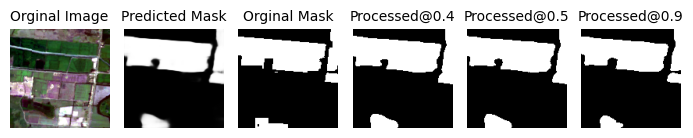

276/276 ━━━━━━━━━━━━━━━━━━━━ 33s 121ms/step - iou_score: 0.8486 - loss: 0.1137 - val_iou_score: 0.8367 - val_loss: 0.1291
Epoch 16/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


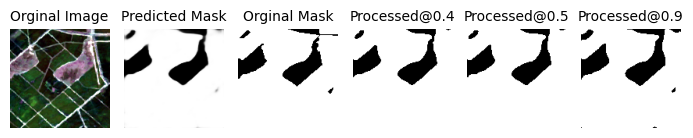

276/276 ━━━━━━━━━━━━━━━━━━━━ 75s 272ms/step - iou_score: 0.8670 - loss: 0.0997 - val_iou_score: 0.8583 - val_loss: 0.1017
Epoch 17/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


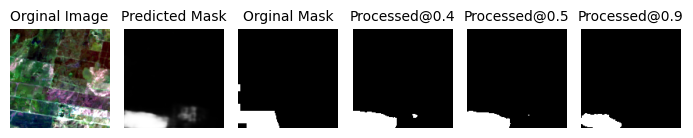

276/276 ━━━━━━━━━━━━━━━━━━━━ 33s 120ms/step - iou_score: 0.8757 - loss: 0.0927 - val_iou_score: 0.8658 - val_loss: 0.1053
Epoch 18/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


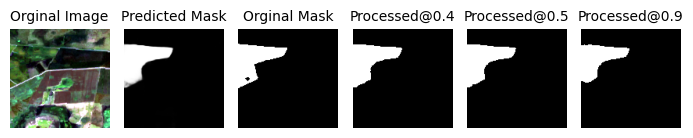

276/276 ━━━━━━━━━━━━━━━━━━━━ 34s 122ms/step - iou_score: 0.8889 - loss: 0.0824 - val_iou_score: 0.8484 - val_loss: 0.1287
Epoch 19/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


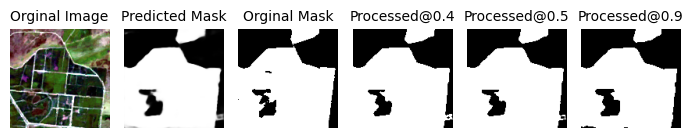

276/276 ━━━━━━━━━━━━━━━━━━━━ 33s 120ms/step - iou_score: 0.8799 - loss: 0.0894 - val_iou_score: 0.8311 - val_loss: 0.1316
Epoch 20/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


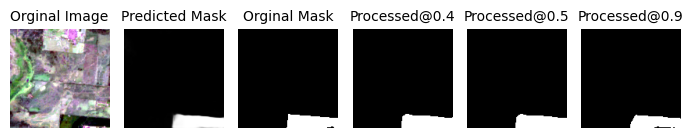

276/276 ━━━━━━━━━━━━━━━━━━━━ 33s 120ms/step - iou_score: 0.8551 - loss: 0.1087 - val_iou_score: 0.8580 - val_loss: 0.1098
Epoch 21/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


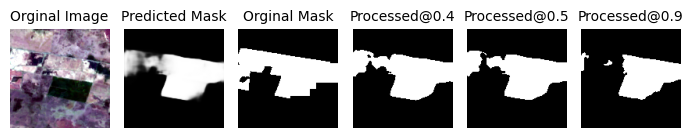

276/276 ━━━━━━━━━━━━━━━━━━━━ 33s 121ms/step - iou_score: 0.8855 - loss: 0.0844 - val_iou_score: 0.8724 - val_loss: 0.1067
Epoch 22/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


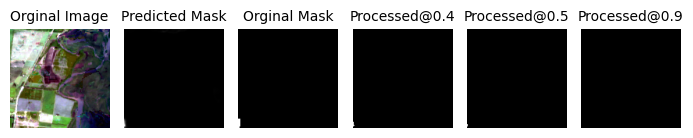

276/276 ━━━━━━━━━━━━━━━━━━━━ 33s 120ms/step - iou_score: 0.8791 - loss: 0.0892 - val_iou_score: 0.7757 - val_loss: 0.1738
Epoch 23/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


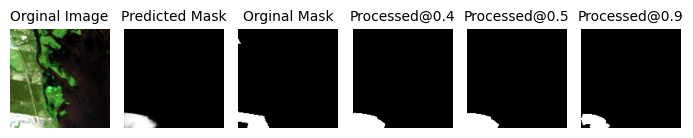

276/276 ━━━━━━━━━━━━━━━━━━━━ 79s 287ms/step - iou_score: 0.8671 - loss: 0.0973 - val_iou_score: 0.8873 - val_loss: 0.0826
Epoch 24/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


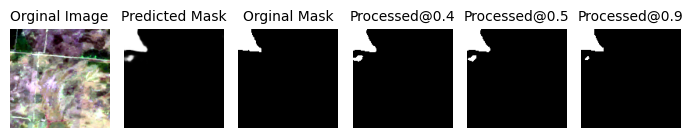

276/276 ━━━━━━━━━━━━━━━━━━━━ 76s 275ms/step - iou_score: 0.9068 - loss: 0.0681 - val_iou_score: 0.9080 - val_loss: 0.0707
Epoch 25/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


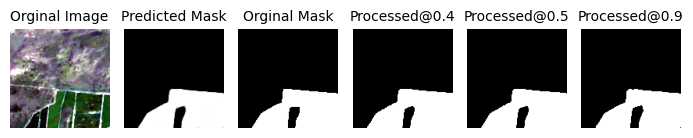

276/276 ━━━━━━━━━━━━━━━━━━━━ 85s 307ms/step - iou_score: 0.9168 - loss: 0.0605 - val_iou_score: 0.9093 - val_loss: 0.0701
Epoch 26/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


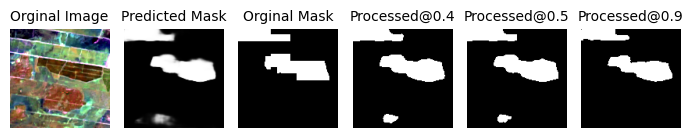

276/276 ━━━━━━━━━━━━━━━━━━━━ 82s 298ms/step - iou_score: 0.9291 - loss: 0.0513 - val_iou_score: 0.9170 - val_loss: 0.0616
Epoch 27/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


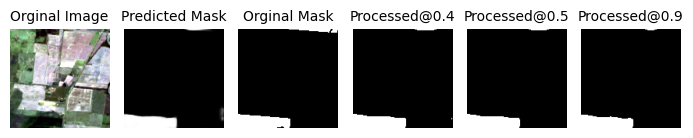

276/276 ━━━━━━━━━━━━━━━━━━━━ 33s 121ms/step - iou_score: 0.9176 - loss: 0.0597 - val_iou_score: 0.8600 - val_loss: 0.1572
Epoch 28/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


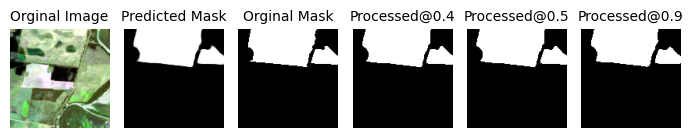

276/276 ━━━━━━━━━━━━━━━━━━━━ 33s 121ms/step - iou_score: 0.9236 - loss: 0.0555 - val_iou_score: 0.9057 - val_loss: 0.0794
Epoch 29/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


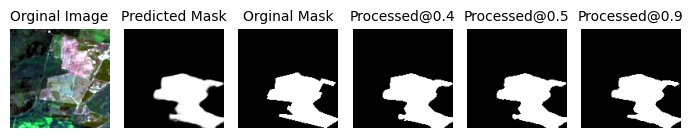

276/276 ━━━━━━━━━━━━━━━━━━━━ 34s 122ms/step - iou_score: 0.9336 - loss: 0.0480 - val_iou_score: 0.9028 - val_loss: 0.0911
Epoch 30/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


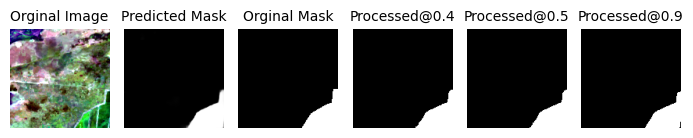

276/276 ━━━━━━━━━━━━━━━━━━━━ 33s 121ms/step - iou_score: 0.8894 - loss: 0.0825 - val_iou_score: 0.8242 - val_loss: 0.1999
Epoch 31/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


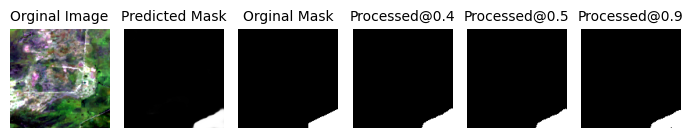

276/276 ━━━━━━━━━━━━━━━━━━━━ 33s 120ms/step - iou_score: 0.8947 - loss: 0.0767 - val_iou_score: 0.9065 - val_loss: 0.0722
Epoch 32/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


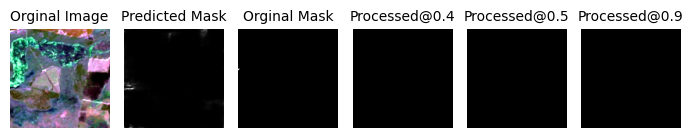

276/276 ━━━━━━━━━━━━━━━━━━━━ 33s 120ms/step - iou_score: 0.9275 - loss: 0.0521 - val_iou_score: 0.9086 - val_loss: 0.0675
Epoch 33/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


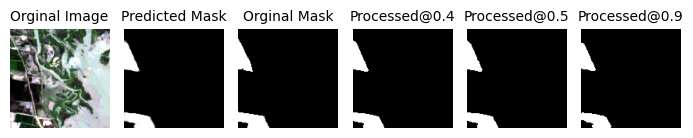

276/276 ━━━━━━━━━━━━━━━━━━━━ 33s 121ms/step - iou_score: 0.9326 - loss: 0.0486 - val_iou_score: 0.9189 - val_loss: 0.0668
Epoch 34/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


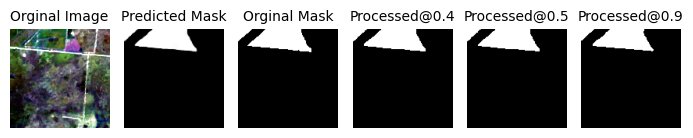

276/276 ━━━━━━━━━━━━━━━━━━━━ 33s 120ms/step - iou_score: 0.9393 - loss: 0.0431 - val_iou_score: 0.9218 - val_loss: 0.0649
Epoch 35/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


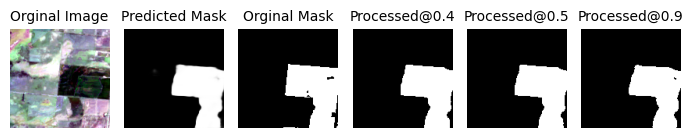

276/276 ━━━━━━━━━━━━━━━━━━━━ 34s 124ms/step - iou_score: 0.9479 - loss: 0.0371 - val_iou_score: 0.9284 - val_loss: 0.0658
Epoch 36/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


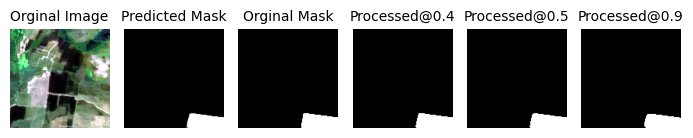

276/276 ━━━━━━━━━━━━━━━━━━━━ 34s 122ms/step - iou_score: 0.9489 - loss: 0.0361 - val_iou_score: 0.9203 - val_loss: 0.0676


In [ ]:
# TRAING THE MODEL
unet_r34.fit(
    x=X_train_A2,
    y=y_train_aug,
    batch_size=16,
    epochs=150,
    validation_data = (X_val, y_val),
    callbacks = callbacks_02
)

#### Trained model metrics evaluation

In [ ]:
# EVALUATE IOU METRIC OF THE TRAINED MODEL

# Define model to evalue
model_ev02 = unet_r34

# Predict with test data
model_ev02_pred = model_test_output(model_ev02, X_test)

# Evaluate trained model and get the best IOU and its threshold
list_iou_resev02, max_iouev02, max_thrsev02 = get_iou(model_ev02_pred, y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 571ms/step


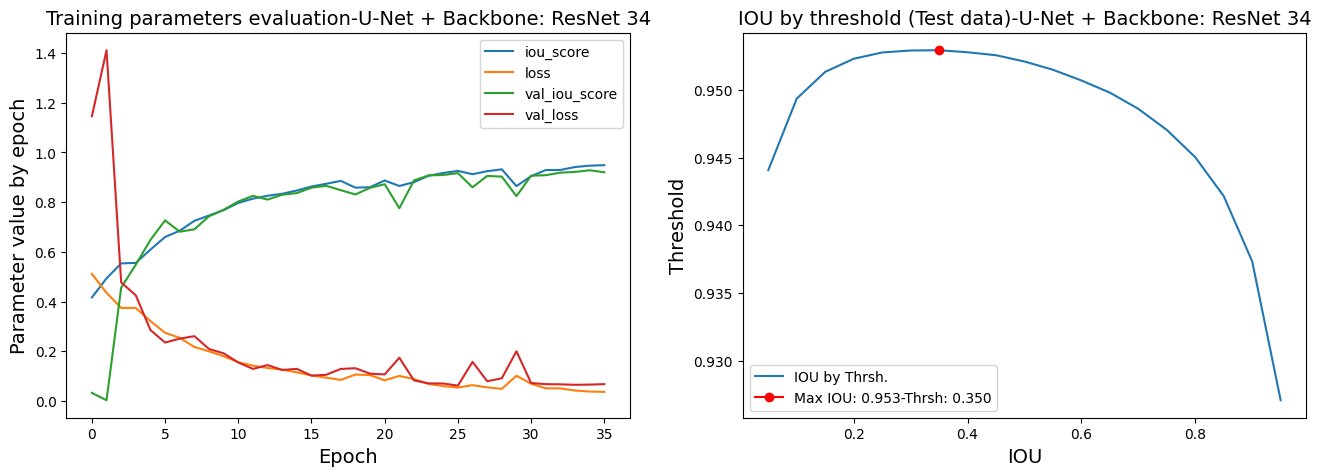

In [ ]:
# PLOT MODEL METRICS

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot training parameters
plot_params_train(model_ev02, axes[0], model_name_str02)
# Plot IOU by threshold and the best case
plot_iou(list_iou_resev02, max_iouev02, max_thrsev02, axes[1], model_name_str02)

plt.show()

In [ ]:
# GET METRICS FOR BEST CASE AND SUMMARY THEM

# Get precission and recall for the beset case
precsev02, recallev02 = get_PRmetrics(model_ev02_pred, y_test, max_thrsev02)

# Summary model metrics
print("FINAL METRICS RESULTS: ", model_name_str02)
print(f"IOU with threshold {max_thrsev02:.3f}: {max_iouev02:.3f}")
print(f"Precision with threshold {max_thrsev02:.3f}: {precsev02:.3f}")
print(f"Recall with threshold {max_thrsev02:.3f}: {recallev02:.3f}")

FINAL METRICS RESULTS:  U-Net + Backbone: ResNet 34
IOU with threshold 0.350: 0.953
Precision with threshold 0.350: 0.965
Recall with threshold 0.350: 0.963


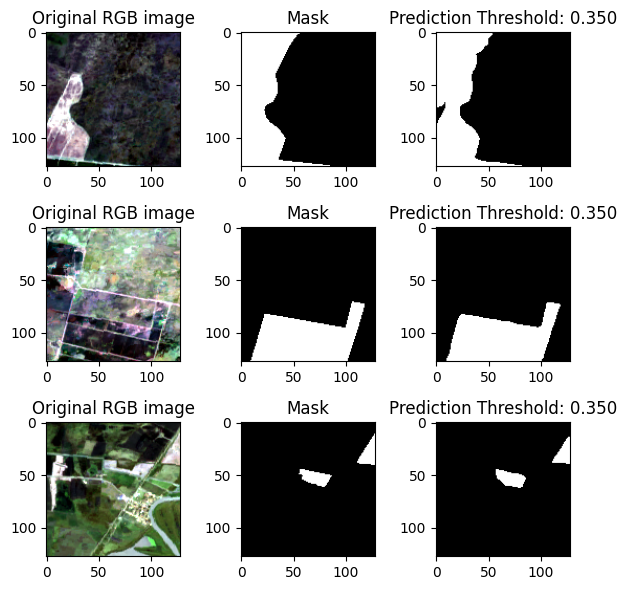

In [ ]:
# PLOT RANDOM PREDICTIONS BASED ON TEST DATA

plot_test_random(X_test, y_test, model_ev02_pred, max_thrsev02)

#### Save and download trained model weights and info

In [ ]:
# GET TRAINED MODEL INFO AND SAVE IT WITH WEIGHTS AS A ZIP FILE

# Get trained model info
path_info_ev02 = create_model_info(model_name_str02, model_ev02, max_iouev02, max_thrsev02, precsev02, recallev02)
# Compress and download model weights and info as a zip file
down_zip(model_name_str02, filename_alt2, path_info_ev02)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Alternative 3**:  U-Net + Backbone: SEResNet 34

#### Model implementation

**NOTE**: U-Nen + SEResNet architecture implementation is based in the [Segmentation Models framework](https://github.com/qubvel/segmentation_models/tree/master)

In [ ]:
# DEFINE UNET ALTERNATIVE COMPONENTS

# Define model name
model_name_str03 = "U-Net + Backbone: SEResNet 34"

# Define backbone
BACKBONE_02 = 'seresnet34'

# Define base model
## The model is initialized using imagenet pretrained weights
base_model_sn34 = Unet(backbone_name=BACKBONE_02, encoder_weights='imagenet')

# Get number of channels
N = X_train.shape[-1] # N = 5. Bands:RGB, NIR & NDVI

# Add extra convolutional layer to map N channels to 3
inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model_sn34(l1)

# Define model
unet_sn34 = Model(inp, out, name=base_model_sn34.name)

# Compile the model
unet_sn34.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=binary_focal_dice_loss,
                  metrics=[iou_score])

# Preprocess training data
#X_train.shape, X_train_aug.shape
preprocess_input = get_preprocessing(BACKBONE_02)
X_train_A3 = preprocess_input(X_train_aug)
X_val_A3 = preprocess_input(X_val)

86315168/86315168 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# DISPLAY SUMMARY (OPTIONAL)
#unet_sn34.summary()

#### Model training

Epoch 1/150
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - iou_score: 0.3571 - loss: 0.5813

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


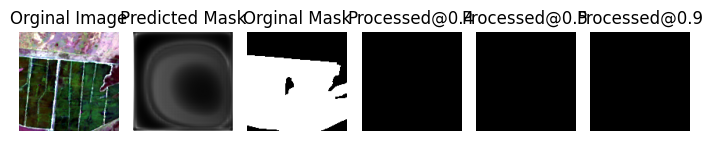

276/276 ━━━━━━━━━━━━━━━━━━━━ 169s 335ms/step - iou_score: 0.3573 - loss: 0.5811 - val_iou_score: 0.0295 - val_loss: 1.1658
Epoch 2/150
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - iou_score: 0.5269 - loss: 0.3969

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


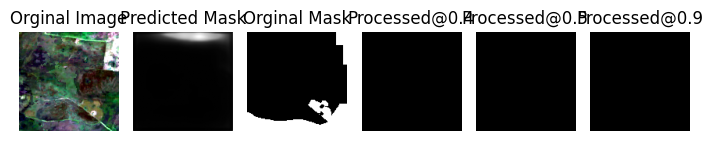

276/276 ━━━━━━━━━━━━━━━━━━━━ 45s 165ms/step - iou_score: 0.5269 - loss: 0.3969 - val_iou_score: 0.1645 - val_loss: 0.9377
Epoch 3/150
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - iou_score: 0.5823 - loss: 0.3449

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


276/276 ━━━━━━━━━━━━━━━━━━━━ 59s 214ms/step - iou_score: 0.5823 - loss: 0.3449 - val_iou_score: 0.4845 - val_loss: 0.5028
Epoch 4/150
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - iou_score: 0.6266 - loss: 0.3048

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


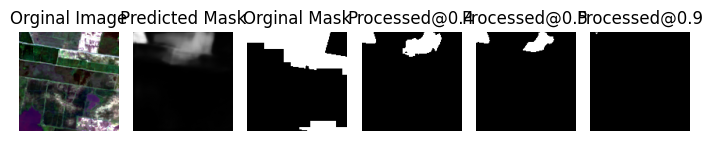

276/276 ━━━━━━━━━━━━━━━━━━━━ 72s 261ms/step - iou_score: 0.6266 - loss: 0.3048 - val_iou_score: 0.6558 - val_loss: 0.2801
Epoch 5/150
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - iou_score: 0.6782 - loss: 0.2552

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


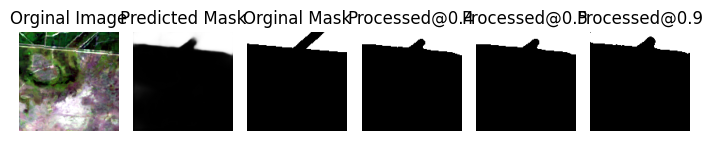

276/276 ━━━━━━━━━━━━━━━━━━━━ 80s 289ms/step - iou_score: 0.6782 - loss: 0.2551 - val_iou_score: 0.7039 - val_loss: 0.2546
Epoch 6/150
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - iou_score: 0.7200 - loss: 0.2219

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


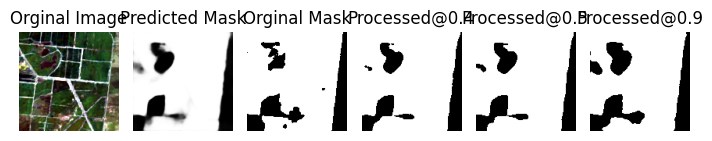

276/276 ━━━━━━━━━━━━━━━━━━━━ 78s 283ms/step - iou_score: 0.7200 - loss: 0.2219 - val_iou_score: 0.7596 - val_loss: 0.1996
Epoch 7/150
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - iou_score: 0.7353 - loss: 0.2085

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


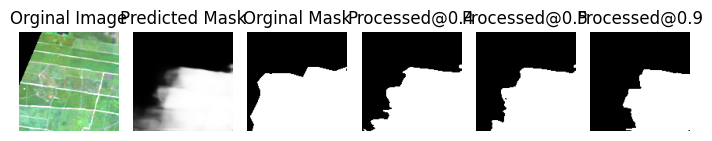

276/276 ━━━━━━━━━━━━━━━━━━━━ 82s 297ms/step - iou_score: 0.7353 - loss: 0.2085 - val_iou_score: 0.7729 - val_loss: 0.1801
Epoch 8/150
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - iou_score: 0.7743 - loss: 0.1741

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


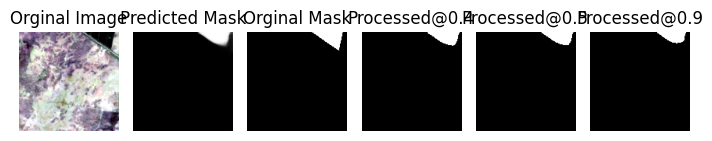

276/276 ━━━━━━━━━━━━━━━━━━━━ 86s 311ms/step - iou_score: 0.7743 - loss: 0.1742 - val_iou_score: 0.7934 - val_loss: 0.1702
Epoch 9/150
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - iou_score: 0.8011 - loss: 0.1523

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


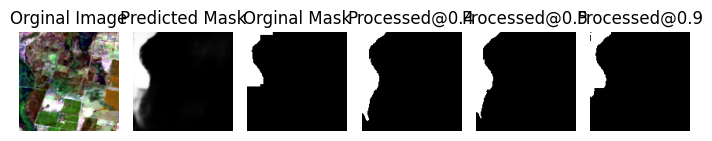

276/276 ━━━━━━━━━━━━━━━━━━━━ 83s 302ms/step - iou_score: 0.8011 - loss: 0.1523 - val_iou_score: 0.7974 - val_loss: 0.1616
Epoch 10/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


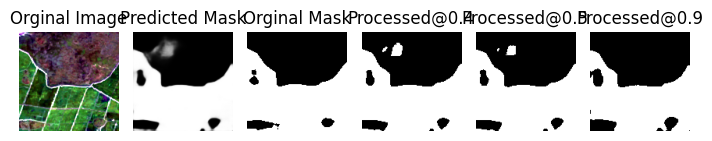

276/276 ━━━━━━━━━━━━━━━━━━━━ 34s 124ms/step - iou_score: 0.8053 - loss: 0.1488 - val_iou_score: 0.7755 - val_loss: 0.1739
Epoch 11/150
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - iou_score: 0.7995 - loss: 0.1533

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


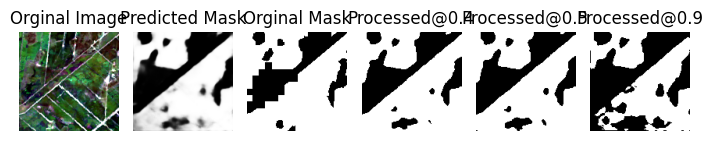

276/276 ━━━━━━━━━━━━━━━━━━━━ 77s 280ms/step - iou_score: 0.7995 - loss: 0.1533 - val_iou_score: 0.7935 - val_loss: 0.1506
Epoch 12/150
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - iou_score: 0.8305 - loss: 0.1283

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


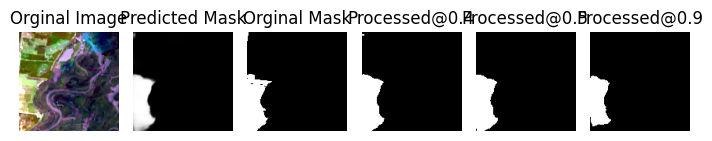

276/276 ━━━━━━━━━━━━━━━━━━━━ 86s 311ms/step - iou_score: 0.8305 - loss: 0.1283 - val_iou_score: 0.8516 - val_loss: 0.1210
Epoch 13/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


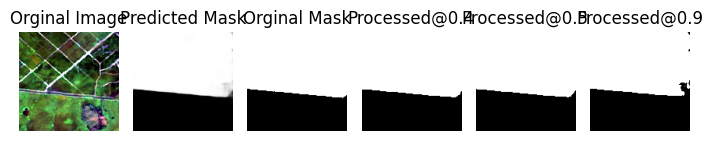

276/276 ━━━━━━━━━━━━━━━━━━━━ 35s 125ms/step - iou_score: 0.8534 - loss: 0.1105 - val_iou_score: 0.8324 - val_loss: 0.1214
Epoch 14/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


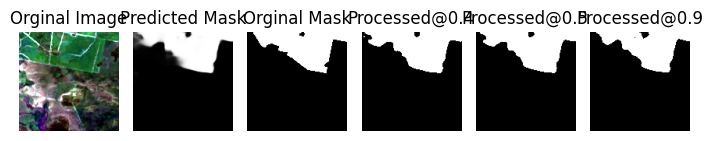

276/276 ━━━━━━━━━━━━━━━━━━━━ 34s 124ms/step - iou_score: 0.8631 - loss: 0.1028 - val_iou_score: 0.8251 - val_loss: 0.1311
Epoch 15/150
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - iou_score: 0.8568 - loss: 0.1075

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


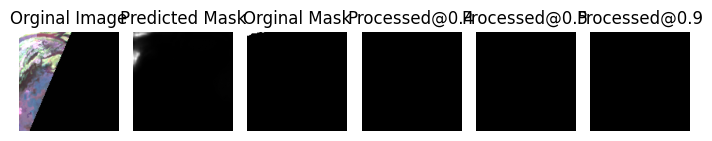

276/276 ━━━━━━━━━━━━━━━━━━━━ 92s 332ms/step - iou_score: 0.8568 - loss: 0.1075 - val_iou_score: 0.8651 - val_loss: 0.0975
Epoch 16/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


276/276 ━━━━━━━━━━━━━━━━━━━━ 34s 125ms/step - iou_score: 0.8809 - loss: 0.0881 - val_iou_score: 0.8593 - val_loss: 0.1072
Epoch 17/150
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - iou_score: 0.8896 - loss: 0.0818

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


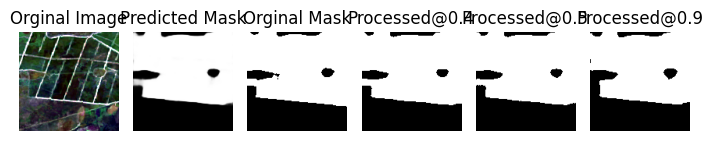

276/276 ━━━━━━━━━━━━━━━━━━━━ 93s 339ms/step - iou_score: 0.8896 - loss: 0.0818 - val_iou_score: 0.8846 - val_loss: 0.0861
Epoch 18/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


276/276 ━━━━━━━━━━━━━━━━━━━━ 35s 125ms/step - iou_score: 0.8969 - loss: 0.0753 - val_iou_score: 0.8845 - val_loss: 0.0874
Epoch 19/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


276/276 ━━━━━━━━━━━━━━━━━━━━ 35s 125ms/step - iou_score: 0.8791 - loss: 0.0911 - val_iou_score: 0.8349 - val_loss: 0.1451
Epoch 20/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


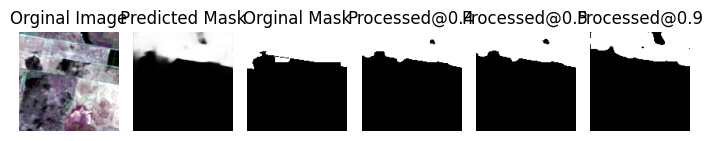

276/276 ━━━━━━━━━━━━━━━━━━━━ 34s 124ms/step - iou_score: 0.8271 - loss: 0.1333 - val_iou_score: 0.8579 - val_loss: 0.0968
Epoch 21/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


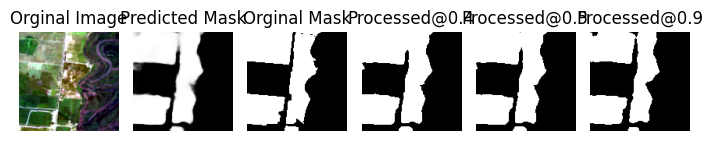

276/276 ━━━━━━━━━━━━━━━━━━━━ 35s 125ms/step - iou_score: 0.8832 - loss: 0.0853 - val_iou_score: 0.8916 - val_loss: 0.0876
Epoch 22/150
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - iou_score: 0.9062 - loss: 0.0688

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


276/276 ━━━━━━━━━━━━━━━━━━━━ 85s 310ms/step - iou_score: 0.9062 - loss: 0.0688 - val_iou_score: 0.9023 - val_loss: 0.0738
Epoch 23/150
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - iou_score: 0.9173 - loss: 0.0598

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


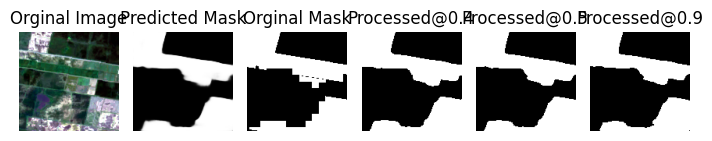

276/276 ━━━━━━━━━━━━━━━━━━━━ 83s 303ms/step - iou_score: 0.9173 - loss: 0.0598 - val_iou_score: 0.9126 - val_loss: 0.0637
Epoch 24/150
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - iou_score: 0.9248 - loss: 0.0540

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


276/276 ━━━━━━━━━━━━━━━━━━━━ 96s 348ms/step - iou_score: 0.9248 - loss: 0.0540 - val_iou_score: 0.9172 - val_loss: 0.0602
Epoch 25/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


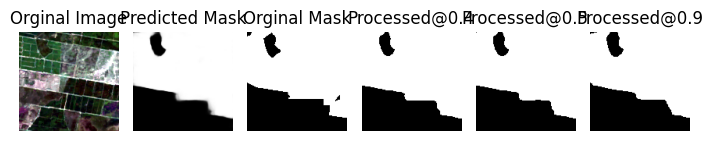

276/276 ━━━━━━━━━━━━━━━━━━━━ 35s 126ms/step - iou_score: 0.9290 - loss: 0.0511 - val_iou_score: 0.9182 - val_loss: 0.0619
Epoch 26/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


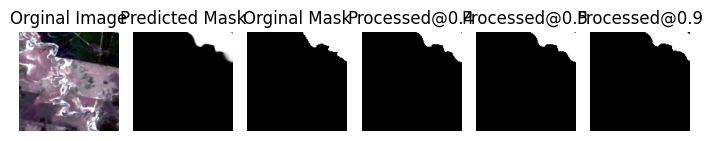

276/276 ━━━━━━━━━━━━━━━━━━━━ 34s 125ms/step - iou_score: 0.9263 - loss: 0.0532 - val_iou_score: 0.9019 - val_loss: 0.0870
Epoch 27/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


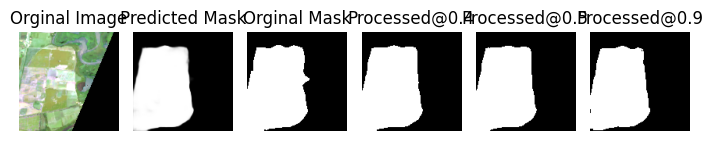

276/276 ━━━━━━━━━━━━━━━━━━━━ 35s 126ms/step - iou_score: 0.9202 - loss: 0.0579 - val_iou_score: 0.8548 - val_loss: 0.1127
Epoch 28/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


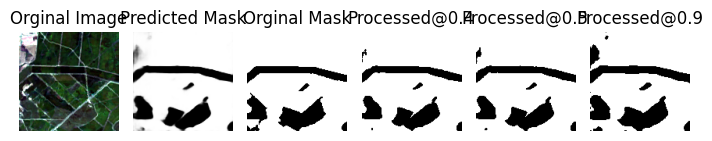

276/276 ━━━━━━━━━━━━━━━━━━━━ 34s 124ms/step - iou_score: 0.9040 - loss: 0.0709 - val_iou_score: 0.8167 - val_loss: 0.1501
Epoch 29/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


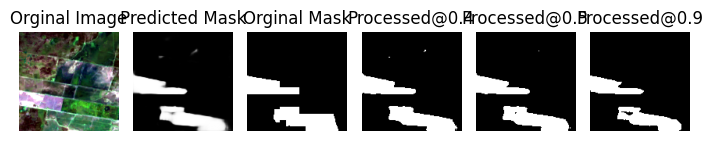

276/276 ━━━━━━━━━━━━━━━━━━━━ 34s 125ms/step - iou_score: 0.8767 - loss: 0.0907 - val_iou_score: 0.8343 - val_loss: 0.1269
Epoch 30/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


276/276 ━━━━━━━━━━━━━━━━━━━━ 35s 125ms/step - iou_score: 0.9020 - loss: 0.0706 - val_iou_score: 0.9135 - val_loss: 0.0644
Epoch 31/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


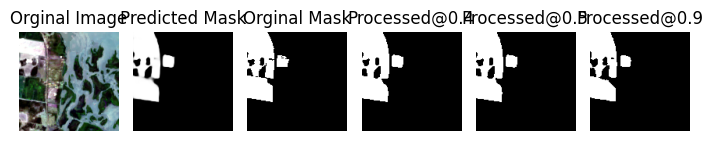

276/276 ━━━━━━━━━━━━━━━━━━━━ 35s 125ms/step - iou_score: 0.9264 - loss: 0.0527 - val_iou_score: 0.9171 - val_loss: 0.0702
Epoch 32/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


276/276 ━━━━━━━━━━━━━━━━━━━━ 36s 131ms/step - iou_score: 0.9344 - loss: 0.0470 - val_iou_score: 0.9218 - val_loss: 0.0632
Epoch 33/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


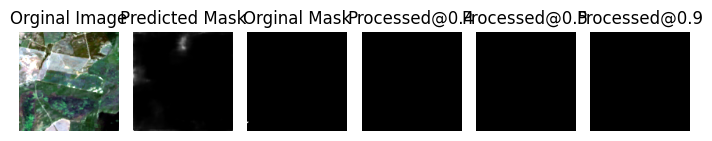

276/276 ━━━━━━━━━━━━━━━━━━━━ 35s 126ms/step - iou_score: 0.9411 - loss: 0.0420 - val_iou_score: 0.9228 - val_loss: 0.0616
Epoch 34/150
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - iou_score: 0.9430 - loss: 0.0404

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


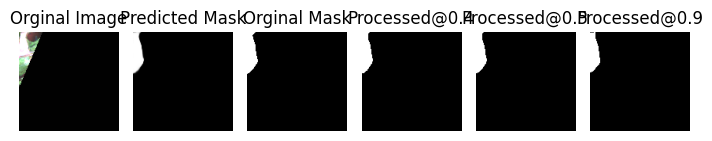

276/276 ━━━━━━━━━━━━━━━━━━━━ 98s 356ms/step - iou_score: 0.9430 - loss: 0.0404 - val_iou_score: 0.9357 - val_loss: 0.0519
Epoch 35/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


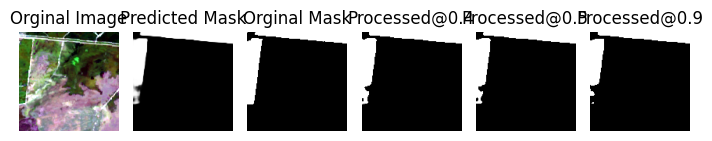

276/276 ━━━━━━━━━━━━━━━━━━━━ 35s 126ms/step - iou_score: 0.9475 - loss: 0.0374 - val_iou_score: 0.9302 - val_loss: 0.0554
Epoch 36/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


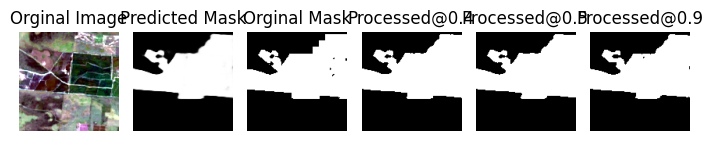

276/276 ━━━━━━━━━━━━━━━━━━━━ 35s 125ms/step - iou_score: 0.9438 - loss: 0.0398 - val_iou_score: 0.9309 - val_loss: 0.0544
Epoch 37/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


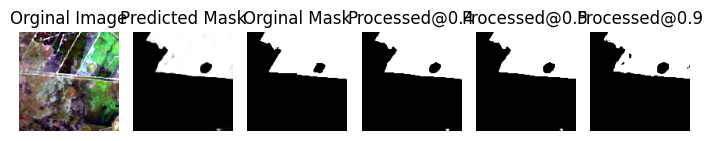

276/276 ━━━━━━━━━━━━━━━━━━━━ 35s 126ms/step - iou_score: 0.9428 - loss: 0.0409 - val_iou_score: 0.8442 - val_loss: 0.1342
Epoch 38/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


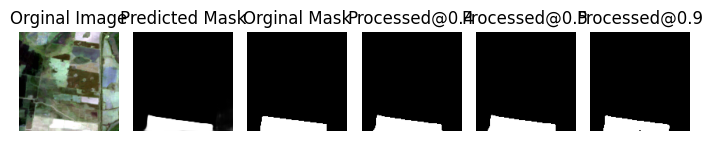

276/276 ━━━━━━━━━━━━━━━━━━━━ 34s 124ms/step - iou_score: 0.9080 - loss: 0.0678 - val_iou_score: 0.8301 - val_loss: 0.1408
Epoch 39/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


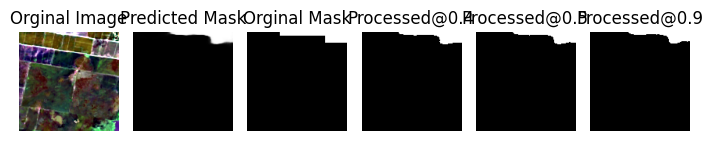

276/276 ━━━━━━━━━━━━━━━━━━━━ 35s 126ms/step - iou_score: 0.9106 - loss: 0.0648 - val_iou_score: 0.9046 - val_loss: 0.0795
Epoch 40/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


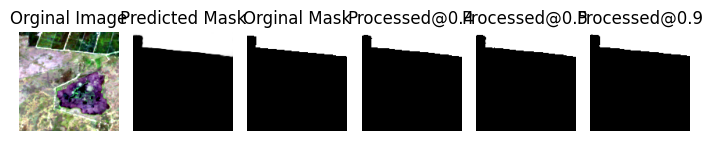

276/276 ━━━━━━━━━━━━━━━━━━━━ 35s 125ms/step - iou_score: 0.9058 - loss: 0.0683 - val_iou_score: 0.9261 - val_loss: 0.0572
Epoch 41/150
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - iou_score: 0.9454 - loss: 0.0386

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


276/276 ━━━━━━━━━━━━━━━━━━━━ 92s 333ms/step - iou_score: 0.9454 - loss: 0.0386 - val_iou_score: 0.9382 - val_loss: 0.0510
Epoch 42/150
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - iou_score: 0.9529 - loss: 0.0333

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


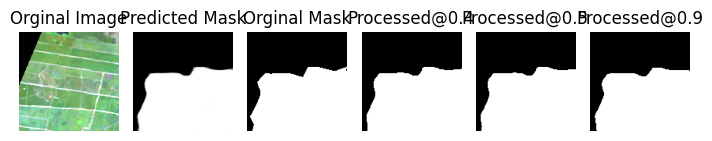

276/276 ━━━━━━━━━━━━━━━━━━━━ 98s 357ms/step - iou_score: 0.9529 - loss: 0.0333 - val_iou_score: 0.9415 - val_loss: 0.0457
Epoch 43/150
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - iou_score: 0.9562 - loss: 0.0307

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


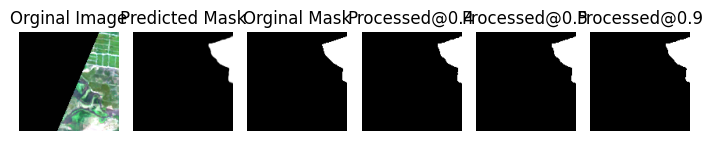

276/276 ━━━━━━━━━━━━━━━━━━━━ 98s 357ms/step - iou_score: 0.9562 - loss: 0.0307 - val_iou_score: 0.9462 - val_loss: 0.0435
Epoch 44/150
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - iou_score: 0.9598 - loss: 0.0283

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


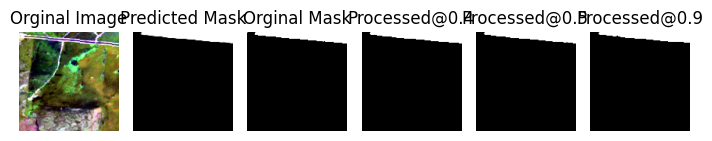

276/276 ━━━━━━━━━━━━━━━━━━━━ 136s 333ms/step - iou_score: 0.9598 - loss: 0.0283 - val_iou_score: 0.9474 - val_loss: 0.0432
Epoch 45/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


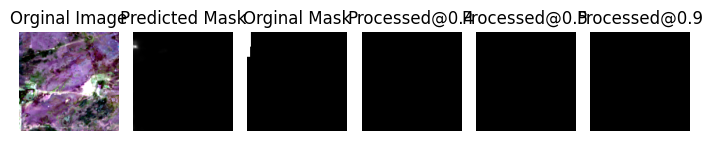

276/276 ━━━━━━━━━━━━━━━━━━━━ 36s 130ms/step - iou_score: 0.9600 - loss: 0.0280 - val_iou_score: 0.9457 - val_loss: 0.0432
Epoch 46/150
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - iou_score: 0.9613 - loss: 0.0271

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


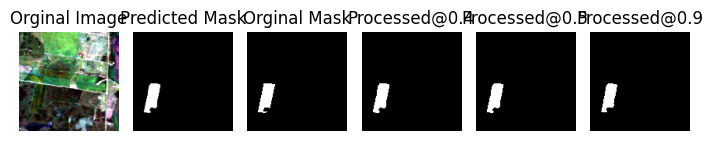

276/276 ━━━━━━━━━━━━━━━━━━━━ 102s 369ms/step - iou_score: 0.9613 - loss: 0.0271 - val_iou_score: 0.9503 - val_loss: 0.0426
Epoch 47/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


276/276 ━━━━━━━━━━━━━━━━━━━━ 36s 129ms/step - iou_score: 0.9613 - loss: 0.0271 - val_iou_score: 0.7635 - val_loss: 0.2092
Epoch 48/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


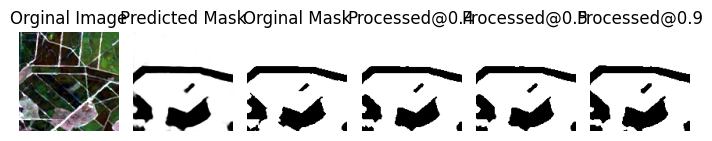

276/276 ━━━━━━━━━━━━━━━━━━━━ 35s 126ms/step - iou_score: 0.8865 - loss: 0.0842 - val_iou_score: 0.8736 - val_loss: 0.0923
Epoch 49/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


276/276 ━━━━━━━━━━━━━━━━━━━━ 34s 124ms/step - iou_score: 0.9190 - loss: 0.0585 - val_iou_score: 0.9346 - val_loss: 0.0519
Epoch 50/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


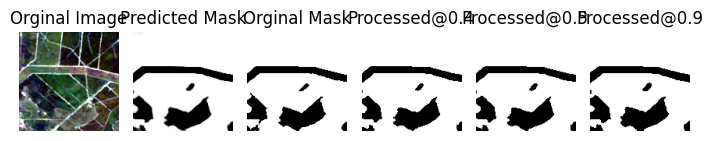

276/276 ━━━━━━━━━━━━━━━━━━━━ 35s 125ms/step - iou_score: 0.9497 - loss: 0.0355 - val_iou_score: 0.9428 - val_loss: 0.0436
Epoch 51/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


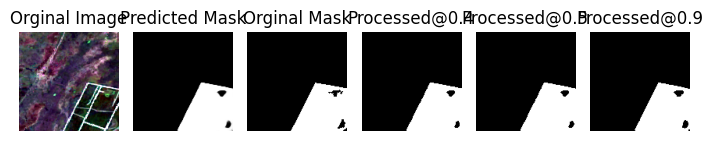

276/276 ━━━━━━━━━━━━━━━━━━━━ 34s 125ms/step - iou_score: 0.9573 - loss: 0.0298 - val_iou_score: 0.9393 - val_loss: 0.0467
Epoch 52/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


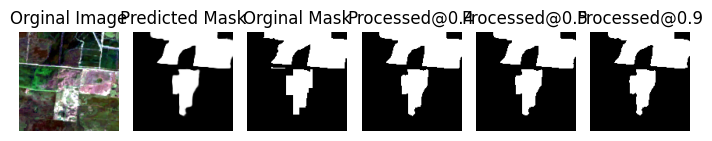

276/276 ━━━━━━━━━━━━━━━━━━━━ 35s 126ms/step - iou_score: 0.9523 - loss: 0.0334 - val_iou_score: 0.9230 - val_loss: 0.0623
Epoch 53/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


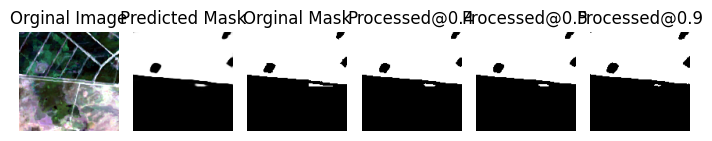

276/276 ━━━━━━━━━━━━━━━━━━━━ 35s 125ms/step - iou_score: 0.9438 - loss: 0.0401 - val_iou_score: 0.9453 - val_loss: 0.0434
Epoch 54/150
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - iou_score: 0.9598 - loss: 0.0282

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


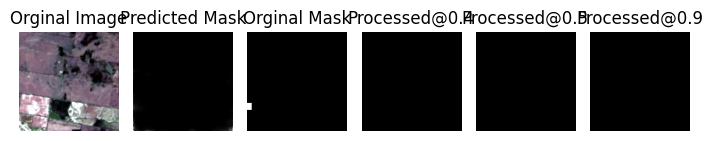

276/276 ━━━━━━━━━━━━━━━━━━━━ 104s 377ms/step - iou_score: 0.9598 - loss: 0.0282 - val_iou_score: 0.9510 - val_loss: 0.0404
Epoch 55/150
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - iou_score: 0.9643 - loss: 0.0247

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


276/276 ━━━━━━━━━━━━━━━━━━━━ 84s 305ms/step - iou_score: 0.9643 - loss: 0.0247 - val_iou_score: 0.9532 - val_loss: 0.0389
Epoch 56/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


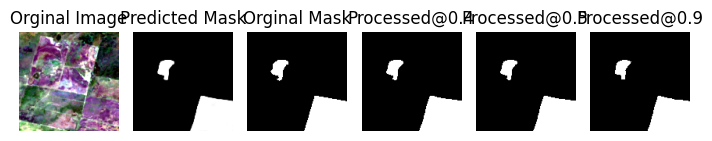

276/276 ━━━━━━━━━━━━━━━━━━━━ 36s 132ms/step - iou_score: 0.9673 - loss: 0.0227 - val_iou_score: 0.9543 - val_loss: 0.0398
Epoch 57/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


276/276 ━━━━━━━━━━━━━━━━━━━━ 36s 129ms/step - iou_score: 0.9686 - loss: 0.0220 - val_iou_score: 0.9547 - val_loss: 0.0422
Epoch 58/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


276/276 ━━━━━━━━━━━━━━━━━━━━ 35s 128ms/step - iou_score: 0.9685 - loss: 0.0219 - val_iou_score: 0.9558 - val_loss: 0.0392
Epoch 59/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


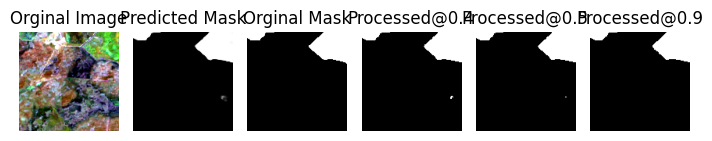

276/276 ━━━━━━━━━━━━━━━━━━━━ 36s 129ms/step - iou_score: 0.9701 - loss: 0.0207 - val_iou_score: 0.9578 - val_loss: 0.0403
Epoch 60/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


276/276 ━━━━━━━━━━━━━━━━━━━━ 36s 129ms/step - iou_score: 0.9704 - loss: 0.0205 - val_iou_score: 0.9561 - val_loss: 0.0397
Epoch 61/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


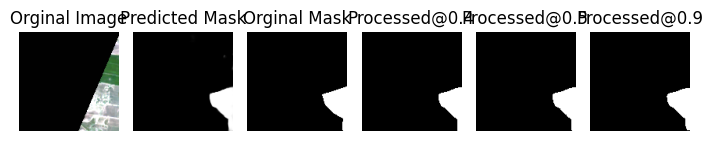

276/276 ━━━━━━━━━━━━━━━━━━━━ 36s 130ms/step - iou_score: 0.9454 - loss: 0.0414 - val_iou_score: 0.8645 - val_loss: 0.1282
Epoch 62/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


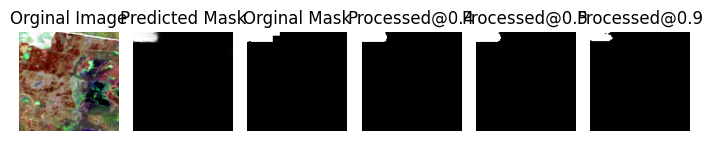

276/276 ━━━━━━━━━━━━━━━━━━━━ 35s 127ms/step - iou_score: 0.9099 - loss: 0.0655 - val_iou_score: 0.9239 - val_loss: 0.0647
Epoch 63/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


276/276 ━━━━━━━━━━━━━━━━━━━━ 36s 129ms/step - iou_score: 0.9472 - loss: 0.0373 - val_iou_score: 0.9433 - val_loss: 0.0471
Epoch 64/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


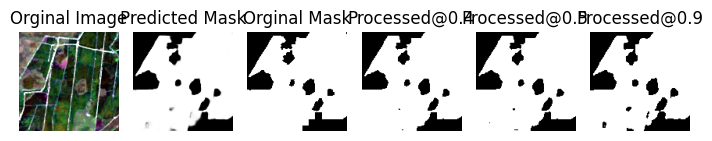

276/276 ━━━━━━━━━━━━━━━━━━━━ 41s 129ms/step - iou_score: 0.9602 - loss: 0.0277 - val_iou_score: 0.9488 - val_loss: 0.0422
Epoch 65/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


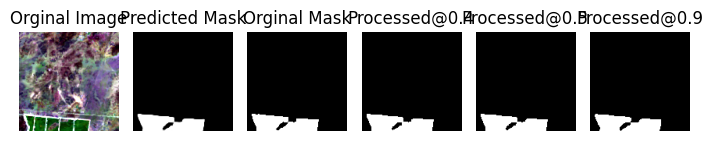

276/276 ━━━━━━━━━━━━━━━━━━━━ 35s 128ms/step - iou_score: 0.9650 - loss: 0.0245 - val_iou_score: 0.9540 - val_loss: 0.0392


In [ ]:
# TRAING THE MODEL
unet_sn34.fit(
    x=X_train_A3,
    y=y_train_aug,
    batch_size=16,
    epochs=150,
    validation_data = (X_val_A3, y_val),
    callbacks = callbacks_03
)

#### Trained model metrics evaluation

In [ ]:
# EVALUATE IOU METRIC OF THE TRAINED MODEL

# Define model to evalue
model_ev03 = unet_sn34

# Predict with test data
model_ev03_pred = model_test_output(model_ev03, X_test)

# Evaluate trained model and get the best IOU and its threshold
list_iou_resev03, max_iouev03, max_thrsev03 = get_iou(model_ev03_pred, y_test)

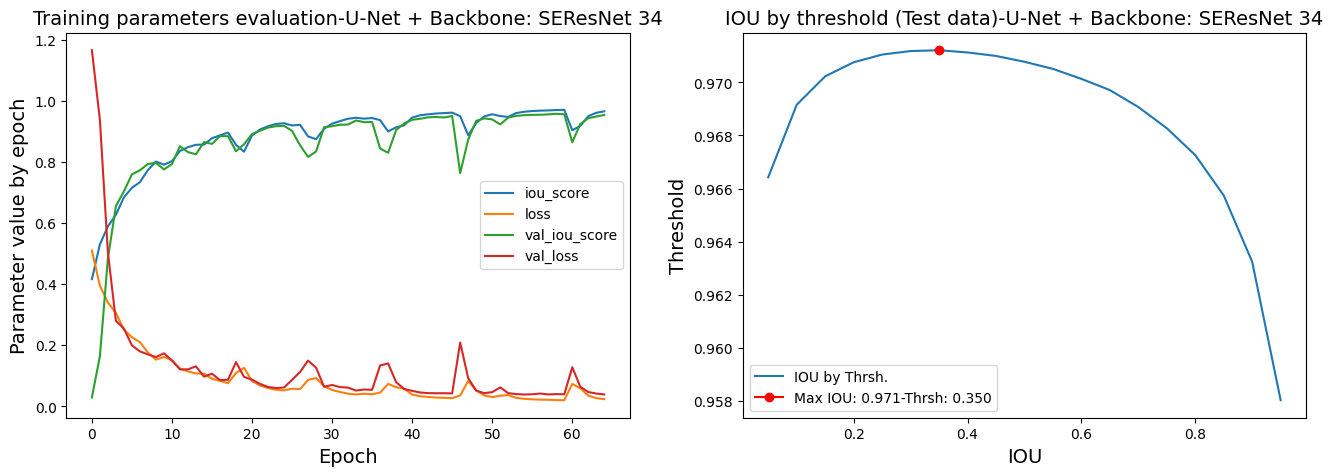

In [ ]:
# PLOT MODEL METRICS

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot training parameters
plot_params_train(model_ev03, axes[0], model_name_str03)

# Plot IOU by threshold and the best case
plot_iou(list_iou_resev03, max_iouev03, max_thrsev03, axes[1], model_name_str03)

plt.show()

In [ ]:
# GET METRICS FOR BEST CASE AND SUMMARY THEM

# Get precission and recall for the beset case
precsev03, recallev03 = get_PRmetrics(model_ev03_pred, y_test, max_thrsev03)

# Summary model metrics
print("FINAL METRICS RESULTS: ", model_name_str03)
print(f"IOU with threshold {max_thrsev03:.3f}: {max_iouev03:.3f}")
print(f"Precision with threshold {max_thrsev03:.3f}: {precsev03:.3f}")
print(f"Recall with threshold {max_thrsev03:.3f}: {recallev03:.3f}")

FINAL METRICS RESULTS:  U-Net + Backbone: SEResNet 34
IOU with threshold 0.350: 0.971
Precision with threshold 0.350: 0.979
Recall with threshold 0.350: 0.977


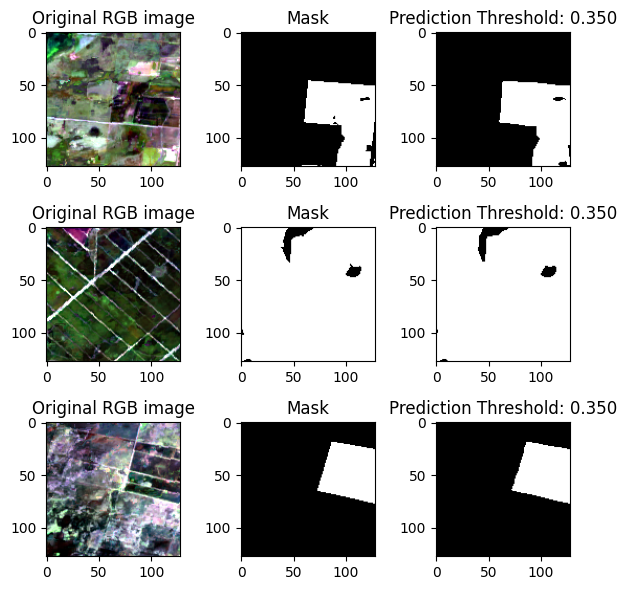

In [ ]:
# PLOT RANDOM PREDICTIONS BASED ON TEST DATA

plot_test_random(X_test, y_test, model_ev03_pred, max_thrsev03)

#### Save and download trained model weights and info

In [ ]:
# GET TRAINED MODEL INFO AND SAVE IT WITH WEIGHTS AS A ZIP FILE

# Get trained model info
path_info_ev03 = create_model_info(model_name_str03, model_ev03, max_iouev03, max_thrsev03, precsev03, recallev03)
# Compress and download model weights and info as a zip file
down_zip(model_name_str03, filename_alt3, path_info_ev03)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>